# PREDICTING HOSPITAL LENGTH OF STAY
## Main code using 3- class classification models

In [ ]:
#importing the necessary libraries
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification

In [14]:
# configure settings for visualizations

sns.set_style('darkgrid')  
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']= (8,6)
plt.rcParams['figure.facecolor']= 'white'

In [15]:
conn = psycopg2.connect(                      #establishing connection to database
           host='localhost',   #database host name
           database = 'mimic',  # database name
           user = 'postgres',   # database user name
           port = '5432',      #database port number
           password='Ram739ad') # database password
           
cur = conn.cursor()              # create a cursor object for executing queries


## Importing Mimiciii data from database

In [16]:
#selecting combined colums from admission table and patients table and calculating age and length of stay from database
query = """
SELECT 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) 
    as age, 
  round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 0) as los,
  p.subject_id,a.admission_type,a.admission_location,a.discharge_location,a.insurance,a.language,a.religion,a.marital_status,
  p.gender,a.ethnicity,a.diagnosis,a.edregtime,a.edouttime,a.hospital_expire_flag,a.has_chartevents_data
FROM mimiciii.admissions a
INNER JOIN mimiciii.patients p ON a.subject_id = p.subject_id 
"""
combineddf = pd.read_sql_query(query,conn) #execute the query and store the result in a pandas DataFrame

In [17]:
alldata_df = combineddf.copy() #making a copy of the data for future use

## Preliminary exploration of the dataset
### Length of Stay

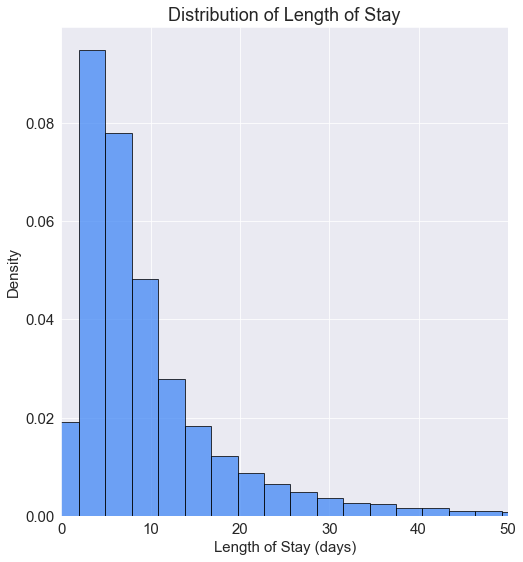

<Figure size 576x432 with 0 Axes>

In [18]:


# create histogram with modified settings
combineddf.los.plot.hist(bins=100, figsize=(8,9), color='#4287f5', density=True, alpha=0.75, edgecolor='black')

# set title, labels, and axis limits
plt.title('Distribution of Length of Stay',fontsize =18) 
plt.xlabel('Length of Stay (days)',fontsize = 15)
plt.ylabel('Density',fontsize=15)
plt.xlim(0, 50)

# show plot
plt.show()

# save plot as PNG file
plt.savefig('LOS_distribution.png')

Generally, the distribution of LOS for the MIMIC-III dataset is positively skewed, with a relatively short median and a long tail of patients with high LOS. This is consistent with the nature of the ICU environment, where patients with severe or complex medical conditions may require prolonged hospitalization and intensive care. Further statiscal test and analysis will be done to investigate the reason for the skewness

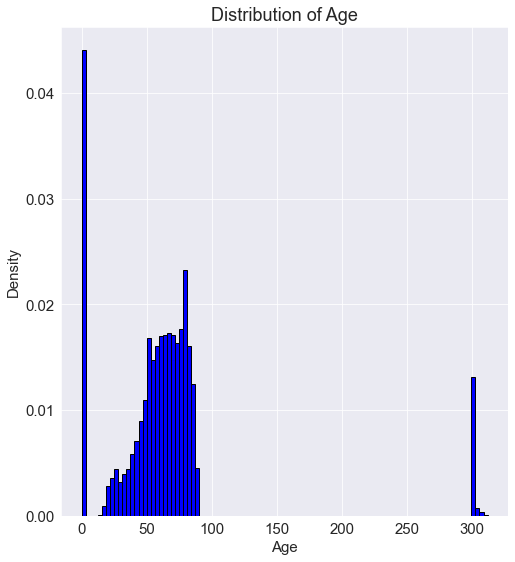

In [19]:
#creating a histogram plot for whole set of data including newborns

# plotting histogram plot and adjusting figure size, 
alldata_df.age.plot.hist(bins =100,figsize = (8,9),density = True,color='b',edgecolor='black') 
plt.title('Distribution of Age') #adding title 
plt.xlabel('Age') # setting x and y labels
plt.ylabel('Density')
plt.show()

The distribution of patient ages in the database shows a roughly normal distribution of patient ages, with a peak in the 0 year old age. Ages are also spread along the ranges from 16 to 80 approximately which suggests that many patients in this age range are most admitted in the hospital, also a peak at the age 300 means that ages 89 and above have been shifted which means that a large number of patients in the MIMIC-III database are elderly, which is consistent with the fact that the database contains data from a tertiary care hospital where critically ill patients are often elderly. 

We will take age into account as a potential confounding factor, or for identifying trends or patterns in the data that may be specific to certain age groups.

Pediatric patients, or those under the age of 16, require specialized care and may have different clinical characteristics and outcomes compared to adult patients. In addition, the regulations regarding the use of pediatric data can be more stringent than those for adult data, which can make it more difficult to work with pediatric data from MIMIC-III.

Therefore, in order to avoid potential confounding factors and ensure the data is appropriate for the research question being investigated, we will exclude pediatric patients and focus on analyzing data from adult patients age 16 and over

## New data with with ICD9 codes and excluding younger patients

In [21]:
#selecting combined colums from admission table and patients table and diagnosis_icd and calculating age and length of stay from 
#database and categorising icd_9 codes into its specific category
query ="""
SELECT 
  CASE 
    WHEN round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) >= 89 
    THEN 89 
    ELSE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) 
  END as age, 
  round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 0) as los,
  p.subject_id,a.hadm_id,a.admission_type,a.admission_location,a.discharge_location,a.insurance,a.language,a.religion,a.marital_status,
  p.gender,a.ethnicity,a.diagnosis,a.edregtime,a.edouttime,d.icd9_code,a.hospital_expire_flag,a.has_chartevents_data,
  CASE 
    WHEN d.icd9_code BETWEEN '001' AND '139' THEN 'Infectious and Parasitic Diseases'
    WHEN d.icd9_code BETWEEN '140' AND '239' THEN 'Neoplasms'
    WHEN d.icd9_code BETWEEN '240' AND '279' THEN 'Endocrine, Nutritional, and Metabolic Diseases and Immunity Disorders'
    WHEN d.icd9_code BETWEEN '280' AND '289' THEN 'Diseases of the Blood and Blood-forming Organs'
    WHEN d.icd9_code BETWEEN '290' AND '319' THEN 'Mental Disorders'
    WHEN d.icd9_code BETWEEN '320' AND '389' THEN 'Diseases of the Nervous System and Sense Organs'
    WHEN d.icd9_code BETWEEN '390' AND '459' THEN 'Diseases of the Circulatory System'
    WHEN d.icd9_code BETWEEN '460' AND '519' THEN 'Diseases of the Respiratory System'
    WHEN d.icd9_code BETWEEN '520' AND '579' THEN 'Diseases of the Digestive System'
    WHEN d.icd9_code BETWEEN '580' AND '629' THEN 'Diseases of the Genitourinary System'
    WHEN d.icd9_code BETWEEN '630' AND '679' THEN 'Complications of Pregnancy, Childbirth, and the Puerperium'
    WHEN d.icd9_code BETWEEN '680' AND '709' THEN 'Diseases of the Skin and Subcutaneous Tissue'
    WHEN d.icd9_code BETWEEN '710' AND '739' THEN 'Diseases of the Musculoskeletal System and Connective Tissue'
    WHEN d.icd9_code BETWEEN '740' AND '759' THEN 'Congenital Anomalies'
    WHEN d.icd9_code BETWEEN '760' AND '779' THEN 'Certain Conditions originating in the Perinatal Period'
    WHEN d.icd9_code BETWEEN '780' AND '799' THEN 'Symptoms, Signs, and Ill-defined Conditions'
    WHEN d.icd9_code BETWEEN '800' AND '999' THEN 'Injury and Poisoning'
    ELSE 'E & V Group'
  END as ccs_group
FROM mimiciii.admissions a
INNER JOIN mimiciii.patients p ON a.subject_id = p.subject_id
INNER JOIN  mimiciii.diagnoses_icd d ON p.subject_id = d.subject_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 2) >= 16
"""

combineddf = pd.read_sql_query(query,conn)
#calculationg the number of comorbidities from the database and adding it to the dataframe
query = """
SELECT hadm_id, COUNT(icd9_code) as num_comorbidities
FROM mimiciii.diagnoses_icd
GROUP BY hadm_id
"""

comorbiditiesdf = pd.read_sql_query(query, conn)
combineddf = pd.merge(combineddf, comorbiditiesdf, on='hadm_id')#execute the query and store the result in a pandas DataFrame
combineddf.head() # printinng first 5 rows of the data

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,language,religion,...,gender,ethnicity,diagnosis,edregtime,edouttime,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,E9317,0,1,E & V Group,9
1,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,042,0,1,Infectious and Parasitic Diseases,9
2,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,1363,0,1,Infectious and Parasitic Diseases,9
3,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,7994,0,1,E & V Group,9
4,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,2763,0,1,"Endocrine, Nutritional, and Metabolic Diseases...",9


## Data Cleaning and Exploration

In [22]:
combineddf.shape ##checking the shape of the dataset

(1325737, 21)

In [23]:
combineddf.duplicated().sum() ## checking for total number of duplicate values in the data

348412

In [24]:
combineddf = combineddf.drop_duplicates(subset=['subject_id'])
combineddf#droping all duplicates in the values

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,language,religion,...,gender,ethnicity,diagnosis,edregtime,edouttime,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,E9317,0,1,E & V Group,9
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,...,F,WHITE,CHRONIC RENAL FAILURE/SDA,NaT,NaT,40391,0,1,Diseases of the Circulatory System,8
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,None,UNOBTAINABLE,...,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 11:13:00,2149-11-09 13:18:00,431,1,1,Diseases of the Circulatory System,6
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,None,OTHER,...,F,WHITE,BRAIN MASS,2178-04-15 20:46:00,2178-04-16 06:53:00,1913,0,1,Neoplasms,1
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,None,JEWISH,...,M,WHITE,PANCREATIC CANCER/SDA,NaT,NaT,1570,1,1,Neoplasms,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325672,58.0,8.0,97497,168949,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,...,M,WHITE,ABDOMINAL PAIN,2106-07-16 08:42:00,2106-07-16 16:15:00,0529,0,1,Infectious and Parasitic Diseases,9
1325681,54.0,3.0,95787,139076,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,PROTESTANT QUAKER,...,F,WHITE,SUBARACHNOID HEMORRHAGE,2135-11-12 23:04:00,2135-11-13 02:51:00,85182,0,1,Injury and Poisoning,12
1325693,38.0,2.0,95793,174563,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,...,F,BLACK/AFRICAN AMERICAN,SICKLE CELL CRISIS,2176-07-02 07:46:00,2176-07-02 14:58:00,28262,0,1,Diseases of the Blood and Blood-forming Organs,6
1325699,68.0,18.0,95798,136645,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,Medicare,ENGL,PROTESTANT QUAKER,...,F,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,2125-11-17 18:42:00,2125-11-18 02:46:00,56983,0,1,Diseases of the Digestive System,14


The data has 1325737 rows and 18 columns, which is very large and could be that since a patient was admitted more than ones there could be duplicates in the dataset. we will handle that by droping all duplicates, however patients may be admitted more than once with different diagnosis, we will check the number of cormobidities.

In [25]:
combineddf.dtypes ##checking data types 

age                            float64
los                            float64
subject_id                       int64
hadm_id                          int64
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
gender                          object
ethnicity                       object
diagnosis                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
icd9_code                       object
hospital_expire_flag             int64
has_chartevents_data             int64
ccs_group                       object
num_comorbidities                int64
dtype: object

The data contains 20 columns out of which 11 have strings data types, two are float, and 4 are interger data type

In [26]:
combineddf.isnull().sum() ##checking for total missing values

age                         0
los                         0
subject_id                  0
hadm_id                     0
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                13785
religion                  425
marital_status           2222
gender                      0
ethnicity                   0
diagnosis                   5
edregtime               15800
edouttime               15800
icd9_code                  20
hospital_expire_flag        0
has_chartevents_data        0
ccs_group                   0
num_comorbidities           0
dtype: int64

Language, edregtime, edouttime contains very large missing data, we will consider dropping these columns to simplify our analysis and reduce the amount of data.

In [27]:
combineddf = combineddf.drop(['language', 'edregtime', 'edouttime'], axis=1) ### dropping language, edregtime and edouttime

In [28]:
# Fill missing icd9_code values with the most common code
most_common_code = combineddf['icd9_code'].mode()[0]
combineddf['icd9_code'] = combineddf['icd9_code'].fillna(most_common_code)


In [29]:
combineddf.duplicated().sum() ## checking for total number of duplicate values in the data

0

In [30]:
comobiditydf = combineddf.copy() ## copying the data into a different variable before dropping duplicate values
comobiditydf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,None,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9


In [31]:
##grouping and calulating the median length of stay by number of comorbidities
median_los = comobiditydf.groupby('num_comorbidities')['los'].median()
comobiditydf['median_los_comorbidities'] = comobiditydf['num_comorbidities'].map(median_los)
comobiditydf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities,median_los_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9,8.0
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8,6.0
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,None,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6,5.0
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1,3.0
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9,8.0


In [28]:
comobiditydf = comobiditydf.drop_duplicates(subset=['hadm_id']) #drop duplicates in hadm_id column

In [32]:
comobiditydf['subject_id'].duplicated().sum() #checking for duplicate values in subject_id column

0

In [33]:
comobiditydf.shape ## checking the shape after dropping duplicates

(38637, 19)

The size of the data has dropped significantly to 38,637 which means that there were a lot of patients who were admitted more than once

In [34]:
comobiditydf.duplicated().sum() ## checking duplicates again

0

In [35]:
comobiditydf.isnull().sum() #check for missing values in the dataset

age                            0
los                            0
subject_id                     0
hadm_id                        0
admission_type                 0
admission_location             0
discharge_location             0
insurance                      0
religion                     425
marital_status              2222
gender                         0
ethnicity                      0
diagnosis                      5
icd9_code                      0
hospital_expire_flag           0
has_chartevents_data           0
ccs_group                      0
num_comorbidities              0
median_los_comorbidities       0
dtype: int64

Religion, marital_status, diagnosis and icd9_code contains some missing data however since the number of missing values is not significant we threat this by filling them with the mode

In [36]:
## filling the missing columns with the modes
cols_to_impute = ['icd9_code', 'marital_status', 'diagnosis', 'religion']
for col in cols_to_impute:
    most_common_value = comobiditydf[col].mode()[0]
    comobiditydf[col] = comobiditydf[col].fillna(most_common_value)


In [37]:
comobiditydf.isnull().sum() ## checking for missing value again

age                         0
los                         0
subject_id                  0
hadm_id                     0
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
religion                    0
marital_status              0
gender                      0
ethnicity                   0
diagnosis                   0
icd9_code                   0
hospital_expire_flag        0
has_chartevents_data        0
ccs_group                   0
num_comorbidities           0
median_los_comorbidities    0
dtype: int64

## Distribution of Length of Stay

       Length of Stay
count        38637.00
mean             9.56
std             10.33
min             -1.00
25%              4.00
50%              7.00
75%             12.00
max            206.00


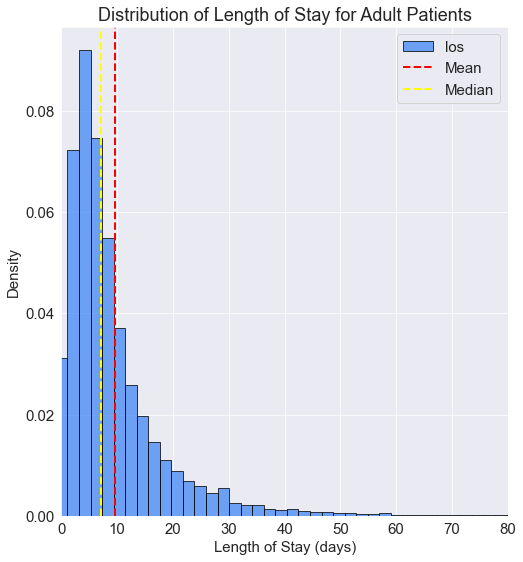

In [38]:

# Calculate the statistical summary of the los column
stats_los = comobiditydf['los'].describe()

# Create a table to display the statistical summary
table = pd.DataFrame(stats_los).round(2)
table.columns = ['Length of Stay']
table.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Print the table
print(table)


# Create a histogram of the los column
comobiditydf.los.plot.hist(bins=100, figsize=(8,9), color='#4287f5', alpha=0.75, edgecolor='black',density=True)
plt.xlim(0,80)
plt.title('Distribution of Length of Stay for Adult Patients',fontsize =18)
plt.xlabel('Length of Stay (days)',fontsize = 15)
plt.ylabel('Density',fontsize = 15)

# Calculate the mean and median values of the los column
mean_los = comobiditydf.los.mean()
median_los = comobiditydf.los.median()

# Add vertical dashed lines for the mean and median values
plt.axvline(mean_los, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_los, color='yellow', linestyle='--', linewidth=2, label='Median')

# Add a legend to the plot
plt.legend()

# Display the figure
plt.show()


The standard deviation is quite large compared to the mean, indicating that the length of stay varies widely across the dataset.
The shortest recorded length of stay is -1, It's likely that this negative value represent some kind of error or missing data. further investigation will be done to acertain this.
25% of patients have a length of stay of 4 days or less.
Half of the patients have a length of stay of 7 days or less, and half have a length of stay of more than 7 days.
75% of patients have a length of stay of 12 days or less.
This is the longest recorded length of stay in the data is 295 days.

In summary, the average length of stay for patients in the dataset is almost 10 days, but there is a lot of variation around this value. The length of stay can range from negative values (which likely represent missing or erroneous data) to as much as 295 days. About 25% of patients are discharged in 4



The plot shows that the distribution of LOS is skewed to the right, indicating that the majority of patients have a shorter stay in the hospital, and there are fewer patients with longer stays.
The plot also shows that the highest frequency of patients has a LOS of approximately 3-5 days, with a gradual decrease in frequency as the LOS increases. Additionally, there seems to be a small bump in the frequency around 20 days, which could indicate a specific pattern or trend in the data. The plot is truncated at 120 days to focus on the majority of patients and not to show outliers with very long LOS. 

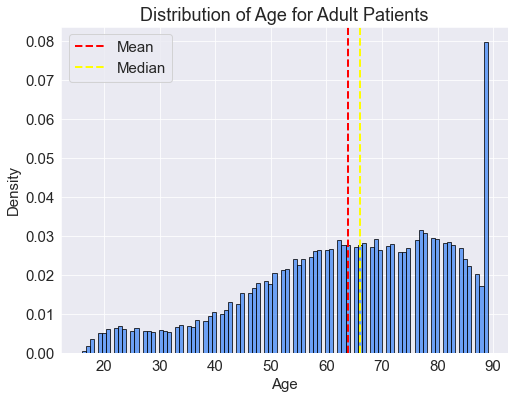

In [39]:
import matplotlib.pyplot as plt

# calculate mean and median age for comobiditydf
comobiditydf_mean = comobiditydf.age.mean()
comobiditydf_median = comobiditydf.age.median()

# plot the histogram of age for comobiditydf
plt.hist(comobiditydf.age, bins=100, density=True, color='#4287f5', alpha=0.75, edgecolor='black')
plt.title('Distribution of Age for Adult Patients')
plt.xlabel('Age')
plt.ylabel('Density')

# add mean and median lines to the plot
plt.axvline(comobiditydf_mean, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(comobiditydf_median, color='yellow', linestyle='--', linewidth=2, label='Median')
plt.legend()

# display the plot
plt.show()


## Distribution of Age

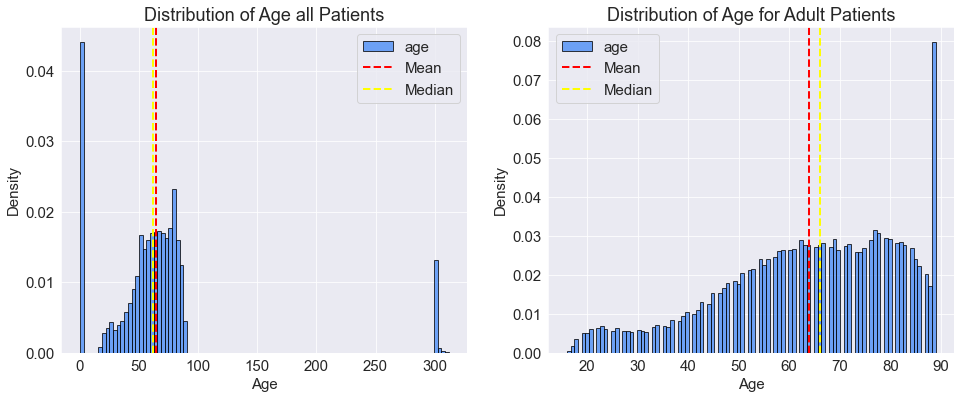

In [40]:

# calculate mean and median of age for combineddf and comobiditydf
alldata_df_mean = alldata_df.age.mean()
alldata_df_median = alldata_df.age.median()
comobiditydf_mean = comobiditydf.age.mean()
comobiditydf_median = comobiditydf.age.median()

# create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the histogram of age for combineddf on the first subplot
alldata_df.age.plot.hist(bins=100, density=True, ax=axs[0], color='#4287f5', alpha=0.75, edgecolor='black')
axs[0].set_title('Distribution of Age all Patients')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')

# add mean and median lines to first subplot
axs[0].axvline(alldata_df_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axs[0].axvline(alldata_df_median, color='yellow', linestyle='--', linewidth=2, label='Median')
axs[0].legend()

# plot the histogram of age for comobiditydf on the second subplot
comobiditydf.age.plot.hist(bins=100, density=True, color='#4287f5', alpha=0.75, edgecolor='black', ax=axs[1])
axs[1].set_title('Distribution of Age for Adult Patients')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Density')

# add mean and median lines to second subplot
axs[1].axvline(comobiditydf_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axs[1].axvline(comobiditydf_median, color='yellow', linestyle='--', linewidth=2, label='Median')
axs[1].legend()

# display the plot
plt.show()


The average age of patients is about 63 years, with a standard deviation of about 17 years, indicating that there is some variability in ages. The youngest patient in the dataset is 16 years old, which is the minimum age requirement to be included in the dataset. The median age is 66 years, indicating that half of the patients are older than this age and half are younger. The interquartile range (IQR) of ages is from 52 to 78 years, indicating that the middle 50% of patients are in this age range. The oldest patient in the dataset is 89 years old, which is the maximum age of patients in the dataset.

## Age and Length of Stay

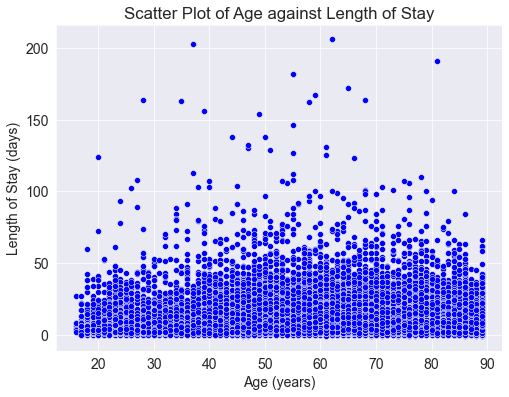

In [41]:
#visualise the distribution of age and loS, with a scatterplot

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
sns.scatterplot(x=comobiditydf['age'],y=comobiditydf['los'],data=comobiditydf, color='blue', marker='o')
plt.title('Scatter Plot of Age against Length of Stay')
plt.xlabel('Age (years)')
plt.ylabel('Length of Stay (days)')
plt.grid(True)


The scatter plot suggests that there is a weak positive correlation between age and length of stay. This means that as the age of the patient increases, the length of stay in the hospital tends to increase slightly. However, the relationship is not very strong, as there are many points scattered throughout the plot with varying ages and lengths of stay.

It is also worth noting that there are some outliers in the plot, which represent patients who have very long lengths of stay in the hospital. These outliers could be the result of severe medical conditions or complications that require extended hospitalization. Additionally, there is a cluster of points in the bottom left corner of the plot, which represent younger patients with relatively short lengths of stay.

## Age categories and length of Stay

In [42]:
comobiditiesdf = comobiditydf.copy() ## making a copy of the datafram for future use
comobiditiesdf.isnull().sum()

age                         0
los                         0
subject_id                  0
hadm_id                     0
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
religion                    0
marital_status              0
gender                      0
ethnicity                   0
diagnosis                   0
icd9_code                   0
hospital_expire_flag        0
has_chartevents_data        0
ccs_group                   0
num_comorbidities           0
median_los_comorbidities    0
dtype: int64

In [43]:
#categorising age into young, mid-age and old and calculating its associated length of stay

# Define the bin edges for the age groups 
bin_edges = [16, 40, 64, 89]

# Use the cut function to assign each age to a category
age_labels = ['young', 'mid-age', 'old']
comobiditiesdf['age_group'] = pd.cut(comobiditiesdf['age'], bins=bin_edges, labels=age_labels)

mode_age_group = comobiditiesdf['age_group'].mode()[0]
comobiditiesdf['age_group'].fillna(mode_age_group, inplace=True)


# Print the first 5 rows of the dataframe with the new age_group column
comobiditiesdf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities,median_los_comorbidities,age_group
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9,8.0,mid-age
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8,6.0,old
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,MARRIED,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6,5.0,mid-age
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1,3.0,mid-age
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9,8.0,old


In [53]:
#create a funtion to plot all neccesary distributions for each column given the data an the column name 

def plot_stats_by_column(df, column):
    # Calculate coefficient of variation for los by selected column
    column_stats = df.groupby(column)['los'].agg(['mean', 'std', 'count'])
    column_stats['cv'] = column_stats['std'] / column_stats['mean']
    column_stats['median'] = df.groupby(column)['los'].median()

    # Plot histograms of los for each value in the selected column
    # create a figure with one row and a number of columns equal to the number of unique values in the column of interest
    fig, axes = plt.subplots(nrows=1, ncols=len(df[column].unique()), figsize=(15,5), sharey=True, gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
    # loop over each unique value in the column of interest
    for i, val in enumerate(df[column].unique()):
        # select the appropriate subplot for the current value
        ax = axes[i]
        # plot a histogram of length of stay for patients with the current value of the column
        ax.hist(df.loc[df[column] == val, 'los'], bins=20, alpha=0.5, color='blue', edgecolor='none', log=True)
        # set the title of the current subplot to the current value of the column
        ax.set_title(f'{val}')
        # set the x-axis label for the current subplot
        ax.set_xlabel('LoS (days)')
        # set the y-axis label for the current subplot
        ax.set_ylabel('Number of Patients (log)')
        # set the limits of the x-axis for the current subplot to the minimum and maximum values of length of stay across all patients
        ax.set_xlim(df['los'].min(), df['los'].max())
         # rotate the x-axis tick labels by 80 degrees for readability
    plt.xticks(rotation=80)
    # set the overall title of the figure to indicate the variable being plotted
    plt.suptitle(f'Distribution of Length of Stay by {column}', fontsize=16, fontweight='bold')



    # set seaborn styles for plots
    sns.set_style('ticks')
    sns.set_palette('Blues')

# create a figure and axis object for plotting
    fig, ax = plt.subplots(figsize=(8, 6))

# create a boxplot of length of stay by the selected column
    sns.boxplot(x=column, y='los', data=df, showfliers=False, palette = 'Blues',ax=ax)

# set the x-axis label of the plot
    ax.set_xlabel(column.capitalize(), fontsize=14)
# set the y-axis label of the plot
    ax.set_ylabel('LoS (Days)', fontsize=14)
# set the title of the plot
    ax.set_title(f'Distribution of Length of Stay by {column}', fontsize=16)

# remove top and right spines from plot
    sns.despine(trim=True)
# add a grid to the plot
    ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
# rotate the x-axis tick labels by 80 degrees for readability
    plt.xticks(rotation=80)
# adjust the layout of the plot to minimize overlap between elements
    plt.tight_layout()

# Create a figure object with two subplots (ax1 and ax2) and set the size of the figure to 12 inches by 6 inches
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create a bar plot with x-axis as the index of the column_stats dataframe, y-axis as 'cv', and color as 'b' for the first subplot
    sns.barplot(x=column_stats.index, y='cv', data=column_stats, color='b', ax=ax1)

# Set the y-axis label for the first subplot
    ax1.set_ylabel('Coefficient of Variation', fontsize=14, color='b')

# Set the color of y-axis labels for the first subplot as blue
    ax1.tick_params(axis='y', labelcolor='b')

# Set the title for the first subplot
    ax1.set_title(f'Variation of Median LOS by {column}', fontsize=16)

# Rotate the x-axis labels for the first subplot by 80 degrees
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

# Create a bar plot with x-axis as the index of the column_stats dataframe, y-axis as 'median', and color as 'g' for the second subplot
    sns.barplot(x=column_stats.index, y='median', data=column_stats, color='g', ax=ax2)

# Set the y-axis label for the second subplot
    ax2.set_ylabel('Median LOS', fontsize=14, color='g')

# Set the color of y-axis labels for the second subplot as green
    ax2.tick_params(axis='y', labelcolor='g')

# Set the title for the second subplot
    ax2.set_title(f'Median LOS by {column}', fontsize=16)

# Rotate the x-axis labels for the second subplot by 80 degrees
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=80)

# Set the general title for the figure object
    fig.suptitle(f'{column} and LoS: Exploring Variation and Median trend', fontsize=20, y=1.05)

# Adjust the spacing between the subplots and the figure boundary
    fig.tight_layout()

# Display the plot
    plt.show()

    # Adjust spacing and layout
    plt.tight_layout()

    # Show the plot
    plt.show()



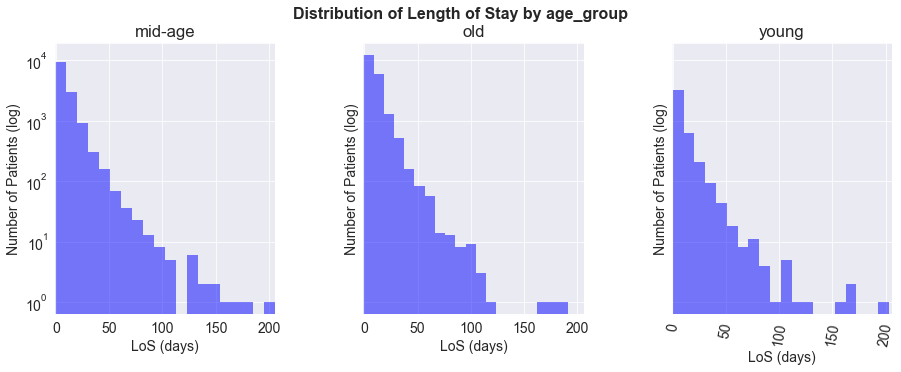

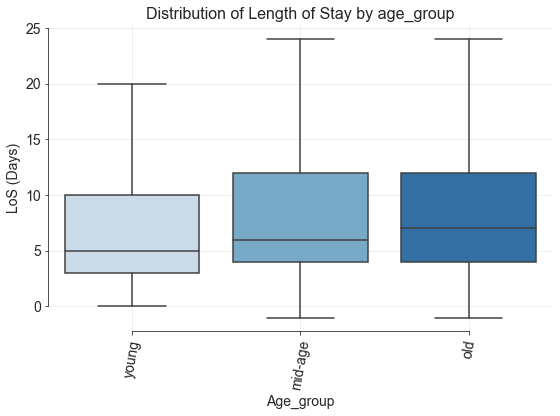

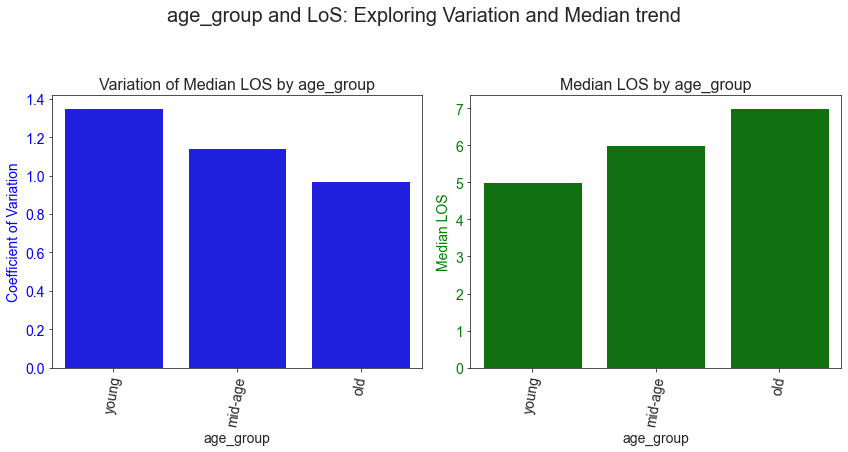

<Figure size 576x432 with 0 Axes>

In [54]:
plot_stats_by_column(comobiditiesdf,'age_group') #plotting all distributions of age groups

Clearly the majority of patients in the dataset are in the 'old' group, followed by the 'mid-age' group and then the 'young' group.

could be that diseases and medical conditions tend to be more common in older individuals, which would explain why the 'old' group is also fairly large. Additionally, the dataset includes only patients who are at least 16 years old, which would naturally exclude a significant proportion of the 'young' group.

Another possibility is that the population being studied (i.e. the patients in the dataset) may simply have a higher proportion of middle-aged and older individuals compared to the general population. This could be due to various factors, such as the types of medical conditions or diseases being studied, the location or demographic characteristics of the healthcare facility where the data was collected. Further analysis and tests will be done to confirm these 

In [55]:
# Group the data by age group and calculate the median of LOS
los_median_by_age_group = comobiditiesdf.groupby('age_group')['los'].median()

# Print the median of LOS for each age group
print(los_median_by_age_group)

age_group
young      5.0
mid-age    6.0
old        7.0
Name: los, dtype: float64


We can see that the median LOS tends to increase with age, with the 'old' group having the highest median LOS. We can also see that there is more variation in LOS within the 'mid-age' and 'old' groups, as evidenced by the longer whiskers and more outliers. further statistical test will be done to confirm if there is a significant differnce in the median age groups

The "young" group has a mean age of 8.75 years, with a standard deviation of 11.58 years. This group has 2,141 members. The coefficient of variation (CV) for this group is 1.32, which indicates a moderate level of variability in age.

The "mid-age" group has a mean age of 10.20 years, with a standard deviation of 12.44 years. This group is the largest, with 13,227 members. The CV for this group is 1.22, indicating a moderate level of variability in age.

The "old" group has a mean age of 9.77 years, with a standard deviation of 9.33 years. This group is the second-largest, with 23,259 members. The CV for this group is 0.96, indicating a relatively low level of variability in age.

##  Admission Type and Length of Stay

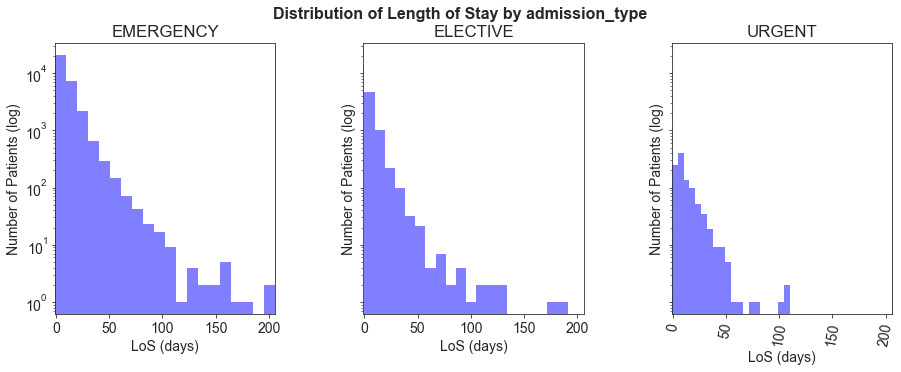

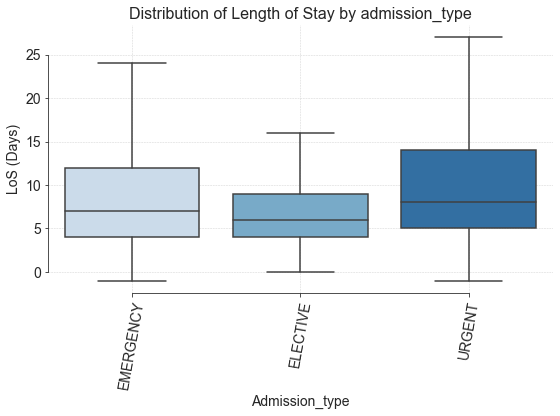

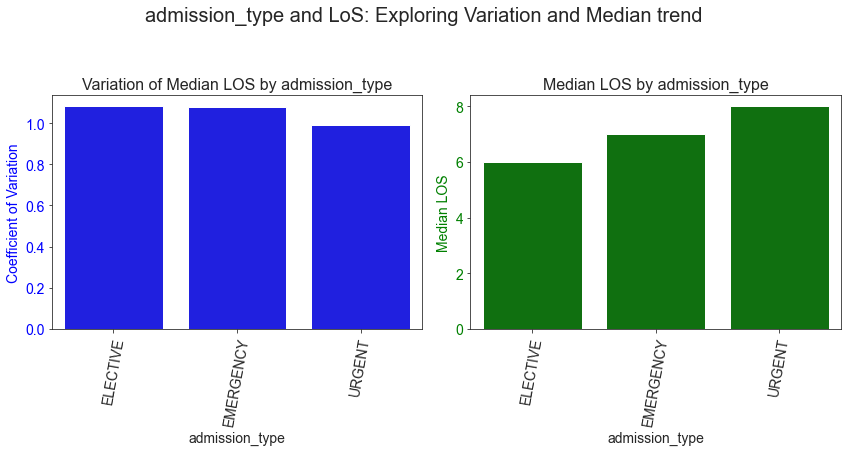

<Figure size 576x432 with 0 Axes>

In [56]:
#ploting distributions of admission type
plot_stats_by_column(comobiditiesdf, 'admission_type')

In [57]:
#finding summay statistics for admission type

comobiditiesdf.head()
# Calculate coefficient of variation for los by admission type
comobiditiesdf['admitype_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by admission type group and calculate los mean and cv
admitype_stats = comobiditiesdf.groupby('admission_type')['los'].agg(['mean', 'std', 'count'])
admitype_stats['cv'] = admitype_stats['std'] / admitype_stats['mean']

print(admitype_stats)




                     mean        std  count        cv
admission_type                                       
ELECTIVE         8.380347   9.069211   6055  1.082200
EMERGENCY        9.727512  10.501277  31561  1.079544
URGENT          11.335945  11.263413   1021  0.993602


## Discharge location and LoS

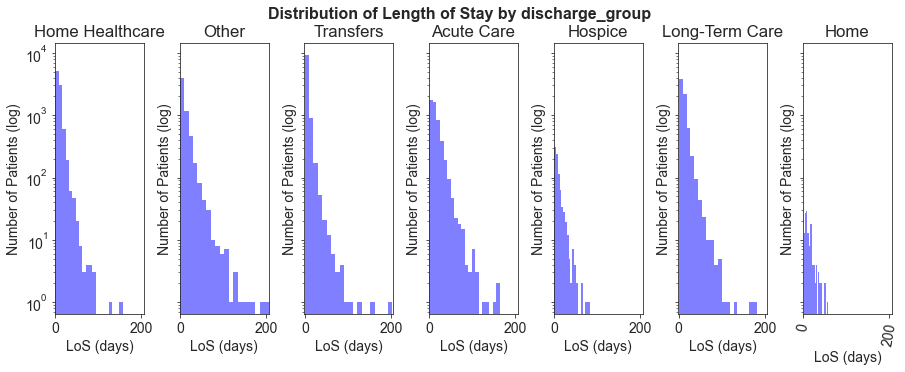

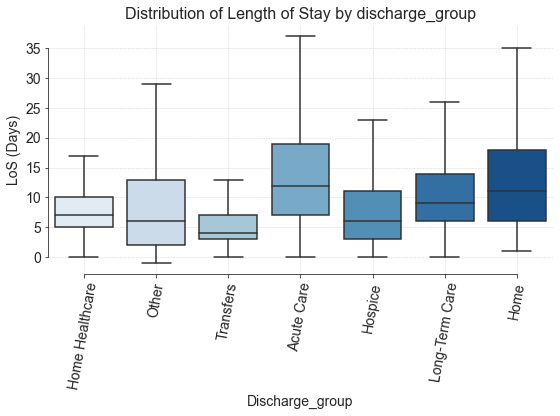

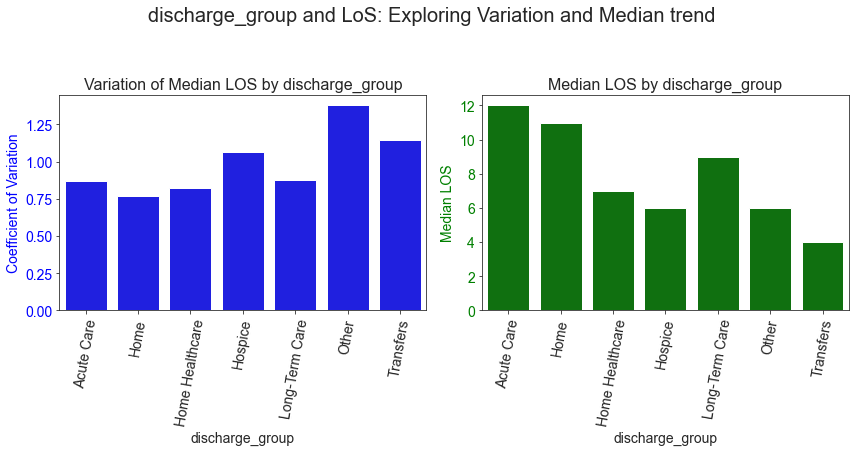

<Figure size 576x432 with 0 Axes>

In [58]:
#grouping discharge location 

data = ['DISC-TRAN CANCER/CHLDRN H', 'HOME HEALTH CARE', 'HOME', 'DEAD/EXPIRED', 'REHAB/DISTINCT PART HOSP', 'LONG TERM CARE HOSPITAL', 'DISC-TRAN TO FEDERAL HC', 'SNF', 'HOSPICE-MEDICAL FACILITY', 'HOME WITH HOME IV PROVIDR', 'HOSPICE-HOME', 'LEFT AGAINST MEDICAL ADVI', 'SHORT TERM HOSPITAL', 'DISCH-TRAN TO PSYCH HOSP', 'OTHER FACILITY', 'ICF', 'SNF-MEDICAID ONLY CERTIF']

groups = {
    'Acute Care': ['SHORT TERM HOSPITAL', 'REHAB/DISTINCT PART HOSP'],
    'Long-Term Care': ['LONG TERM CARE HOSPITAL', 'SNF', 'ICF', 'SNF-MEDICAID ONLY CERTIF'],
    'Home Healthcare': ['HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR'],
    'Home':['HOME','HOSPICE-HOME'],
    'Hospice': ['HOSPICE-MEDICAL FACILITY'],
    'Transfers': ['DISC-TRAN CANCER/CHLDRN H', 'DISC-TRAN TO FEDERAL HC', 'DISCH-TRAN TO PSYCH HOSP']
}
# Initialize an empty dictionary to store the grouped data
grouped_data = {}
# Loop through each group in the 'groups' dictionary
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['discharge_location'].isin(groups['Acute Care']),
    comobiditiesdf['discharge_location'].isin(groups['Long-Term Care']),
    comobiditiesdf['discharge_location'].isin(groups['Home Healthcare']),
    comobiditiesdf['discharge_location'].isin(groups['Hospice']),
    comobiditiesdf['discharge_location'].isin(groups['Transfers']),
    comobiditiesdf['discharge_location'].isin(groups['Home'])
]
# Create a list of choices for each condition
choices = ['Acute Care', 'Long-Term Care', 'Home Healthcare','Home','Hospice', 'Transfers']
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
comobiditiesdf['discharge_group'] = np.select(conditions, choices, default='Other')



plot_stats_by_column(comobiditiesdf,'discharge_group')

## Observation
From the plot, we can see that the majority of patients are discharged to Home Health(the second bar), followed by Long-Term Care and Acute Care (the forth and fifth bars). There are also some patients who are discharged to Hospice and Transfers (the first and fifth bars), but these groups have much lower counts compared to the four groups.

In [59]:
#Calculate coefficient of variation for los
comobiditiesdf['discharge_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by discharge group and calculate los mean and cv
discharge_stats = comobiditiesdf.groupby('discharge_group')['los'].agg(['mean', 'std', 'count'])
discharge_stats['cv'] = discharge_stats['std'] / discharge_stats['mean']


print(discharge_stats)


# Group the data by discharge location and calculate the median of LOS
los_median_by_disch_loc = comobiditiesdf.groupby('discharge_group')['los'].median()

# Print the median of LOS for each age group
print(los_median_by_disch_loc)


                      mean        std  count        cv
discharge_group                                       
Acute Care       15.217564  13.228657   5033  0.869302
Home             13.700000  10.555542    150  0.770478
Home Healthcare   8.805303   7.244323   9240  0.822723
Hospice           9.237248   9.840205    843  1.065275
Long-Term Care   11.630966  10.165551   7040  0.874007
Other             9.998647  13.770630   5913  1.377249
Transfers         5.810136   6.654550  10418  1.145335
discharge_group
Acute Care         12.0
Home               11.0
Home Healthcare     7.0
Hospice             6.0
Long-Term Care      9.0
Other               6.0
Transfers           4.0
Name: los, dtype: float64


## Insurance and Length of Stay

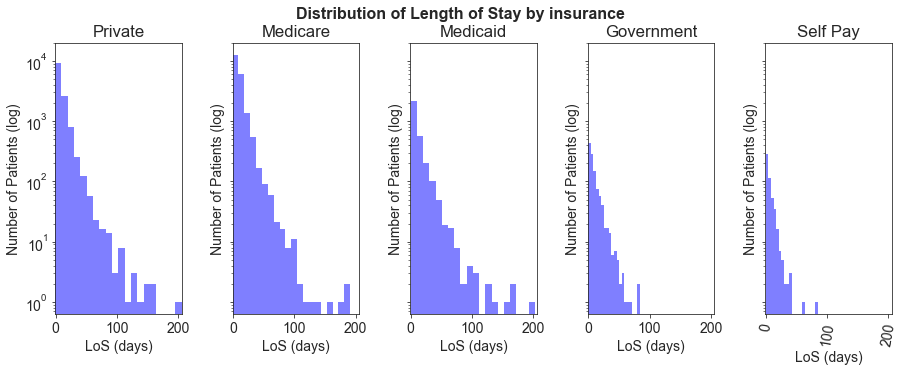

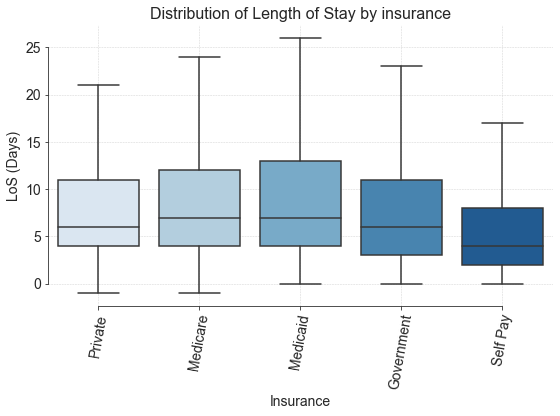

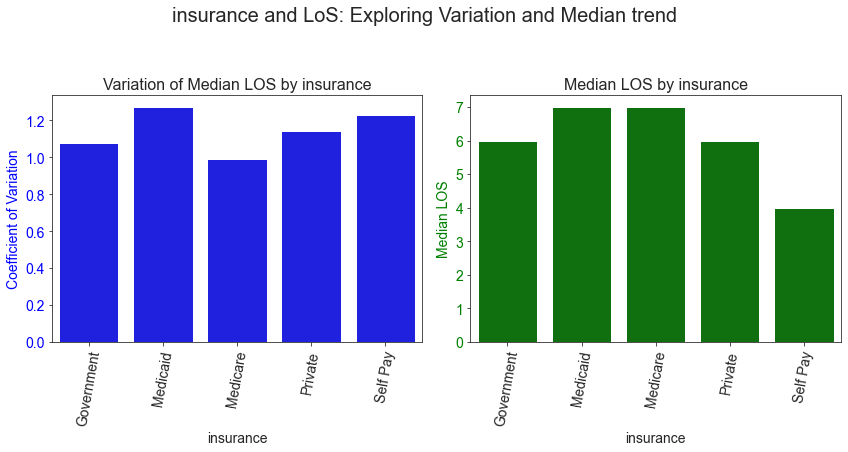

<Figure size 576x432 with 0 Axes>

In [60]:
#encode categories in insurance type
comobiditiesdf['insurance_enc']= np.where(comobiditiesdf['insurance'] == 'Private', 1, 
                                          np.where(comobiditiesdf['insurance']== 'Medicare',2,
                                                   np.where(comobiditiesdf['insurance']== 'Medicaid',3,
                                                           np.where(comobiditiesdf['insurance']=='Self Pay',4,5))))
comobiditiesdf.head()

plot_stats_by_column(comobiditiesdf,'insurance')



In [61]:
# Group the data by insurance type and calculate the median of LOS
los_median_by_insurance = combineddf.groupby('insurance')['los'].median()
# Print the median of LOS for each age group
print(los_median_by_insurance)

insurance
Government    6.0
Medicaid      7.0
Medicare      7.0
Private       6.0
Self Pay      4.0
Name: los, dtype: float64


## Religion and Length of stay

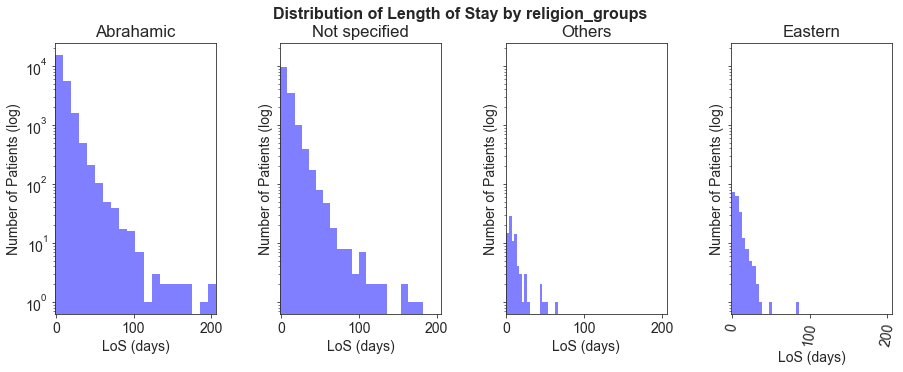

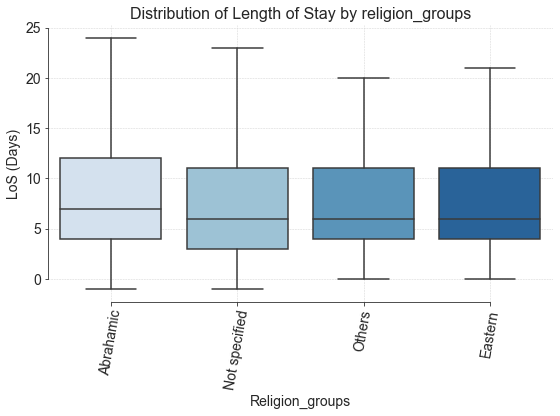

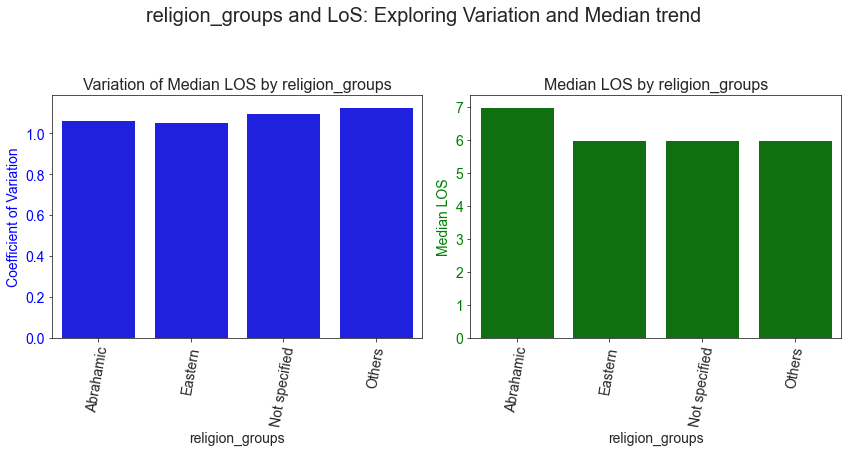

<Figure size 576x432 with 0 Axes>

In [62]:
data = ['UNOBTAINABLE', 'CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'JEWISH', 'BUDDHIST', "JEHOVAH'S WITNESS", 'OTHER', 'NONE',
       'GREEK ORTHODOX', 'EPISCOPALIAN', 'CHRISTIAN SCIENTIST', 'HEBREW',
       'METHODIST', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'BAPTIST',
       '7TH DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST. ORTH', 'LUTHERAN']

groups = {
    'Abrahamic': ['CATHOLIC', 'PROTESTANT QUAKER', 'JEWISH', 'JEHOVAH\'S WITNESS', 'GREEK ORTHODOX', 'EPISCOPALIAN', 
                  'CHRISTIAN SCIENTIST', 'HEBREW', 'METHODIST', 'BAPTIST', '7th DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST ORTH', 
                  'LUTHERAN'],
    'Eastern': ['BUDDHIST', 'HINDU'],
    
    'Others': ['UNITARIAN-UNIVERSALIST']
}

# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['religion'].isin(groups['Abrahamic']),
    comobiditiesdf['religion'].isin(groups['Eastern']),
    comobiditiesdf['religion'].isin(groups['Others']),
]   
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['Abrahamic', 'Eastern', 'Others']
comobiditiesdf['religion_groups'] = np.select(conditions, choices, default='Not specified')

comobiditiesdf.head()


plot_stats_by_column(comobiditiesdf,'religion_groups')

In [63]:
#encoding the religion group column
comobiditiesdf['rel_enc']= np.where(comobiditiesdf['religion_groups'] == 'Abrahamic', 1, 
                                          np.where(comobiditiesdf['religion_groups']== 'Not specified',2,
                                                   np.where(comobiditiesdf['religion_groups']=='Eastern',3,4)))


# Calculate coefficient of variation for los by religion group
comobiditiesdf['religion_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
religion_stats = comobiditiesdf.groupby('religion_groups')['los'].agg(['mean', 'std', 'count'])
religion_stats['cv'] = religion_stats['std'] / religion_stats['mean']


    

print(religion_stats)



# Group the data by discharge location and calculate the median of LOS
los_median_by_rel_group = comobiditiesdf.groupby('religion_groups')['los'].median()
# Print the median of LOS for each age group
print(los_median_by_rel_group)



                      mean        std  count        cv
religion_groups                                       
Abrahamic         9.933815  10.590245  23374  1.066080
Eastern           8.673267   9.144619    202  1.054345
Not specified     8.980968   9.880634  14975  1.100175
Others           10.372093  11.722323     86  1.130179
religion_groups
Abrahamic        7.0
Eastern          6.0
Not specified    6.0
Others           6.0
Name: los, dtype: float64


## ETHINICITY AND LENGTH OF STAY

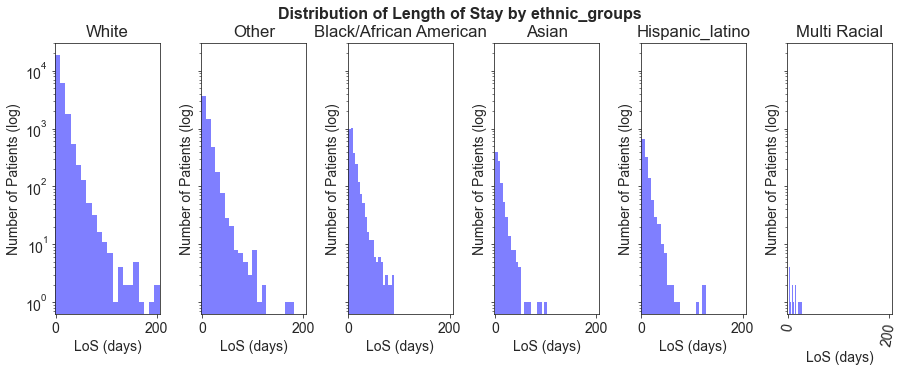

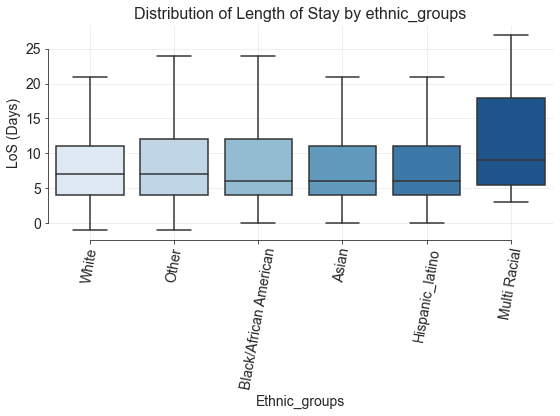

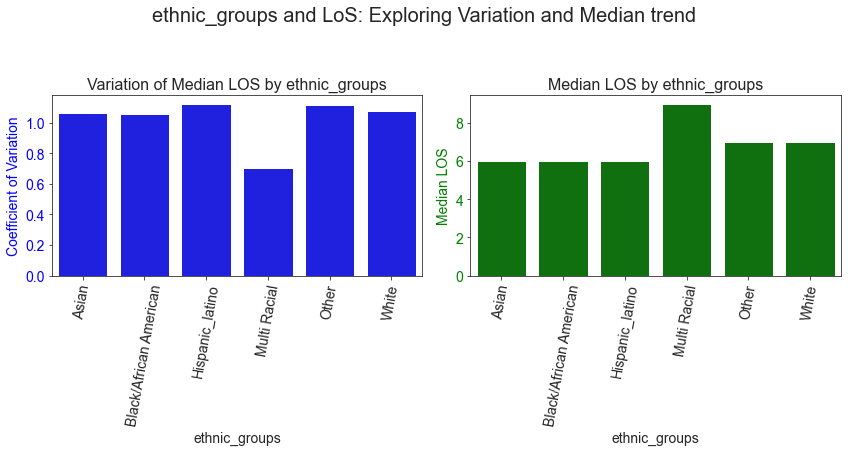

<Figure size 576x432 with 0 Axes>

In [64]:
data = ['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'HISPANIC OR LATINO', 'PATIENT DECLINED TO ANSWER',
       'BLACK/AFRICAN AMERICAN', 'ASIAN', 'HISPANIC/LATINO - GUATEMALAN',
       'OTHER', 'ASIAN - VIETNAMESE', 'AMERICAN INDIAN/ALASKA NATIVE',
       'WHITE - RUSSIAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'PORTUGUESE',
       'CARIBBEAN ISLAND', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'WHITE - BRAZILIAN',
       'ASIAN - KOREAN', 'HISPANIC/LATINO - COLOMBIAN', 'SOUTH AMERICAN',
       'ASIAN - THAI', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - CUBAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MIDDLE EASTERN',
       'ASIAN - OTHER', 'HISPANIC/LATINO - MEXICAN',
       'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ASIAN - JAPANESE']



#creating groups for ethnicity
groups = {
    'White': ['WHITE','WHITE - RUSSIAN','WHITE - OTHER EUROPEAN','WHITE - EASTERN EUROPEAN','WHITE - BRAZILIAN'],
    'Hispanic_latino': ['HISPANIC OR LATINO','HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - PUERTO RICAN',
                        'HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - DOMINICAN',
                        'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - COLOMBIAN',
                        'HISPANIC/LATINO - HONDURAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - MEXICAN'],
    
    'Black/African American': ['BLACK/AFRICAN AMERICAN','BLACK/AFRICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN'],
    'Asian':  ['ASIAN','ASIAN - VIETNAMESE','ASIAN - CHINESE','ASIAN - ASIAN INDIAN','ASIAN - FILIPINO','ASIAN - CAMBODIAN',
              'ASIAN - KOREAN','ASIAN - THAI','ASIAN - JAPANESE'],
    'Other': ['MULTI RACE ETHNICITY','PATIENT DECLINED TO ANSWER','OTHER','PORTUGUESE','CARIBBEAN ISLAND',
                            'SOUTH AMERICAN','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','MIDDLE EASTERN','UNABLE TO OBTAIN'],
    'Multi Racial': ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']
}



# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['ethnicity'].isin(groups['White']),
    comobiditiesdf['ethnicity'].isin(groups['Hispanic_latino']),
    comobiditiesdf['ethnicity'].isin(groups['Black/African American']),
    comobiditiesdf['ethnicity'].isin(groups['Asian']),
    comobiditiesdf['ethnicity'].isin(groups['Multi Racial']),
    comobiditiesdf['ethnicity'].isin(groups['Other'])
]   
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['White','Hispanic_latino','Black/African American','Asian','Multi Racial','Other']
comobiditiesdf['ethnic_groups'] = np.select(conditions, choices, default = 'Other')

comobiditiesdf.head()

#encoding ethnicity column
comobiditiesdf['ethnic_enc']= np.where(comobiditiesdf['ethnic_groups'] == 'White', 1, 
                                          np.where(comobiditiesdf['ethnic_groups']== 'Black/African American',2,
                                                          np.where(comobiditiesdf['ethnic_groups']=='Multi Racial',3,
                                                                   np.where(comobiditiesdf['ethnic_groups']== 'Hispanic_latino',4,
                                                                           np.where(comobiditiesdf['ethnic_groups']== 'Other',5,6)))))

comobiditiesdf.head()


plot_stats_by_column(comobiditiesdf,'ethnic_groups')

In [53]:
# Calculate coefficient of variation for los by religion group
comobiditiesdf['ethnic_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
ethnic_stats = comobiditiesdf.groupby('ethnic_groups')['los'].agg(['mean', 'std', 'count'])
ethnic_stats['cv'] = ethnic_stats['std'] / ethnic_stats['mean']
ethnic_stats


print(ethnic_stats)



# Group the data by discharge location and calculate the median of LOS
los_median_by_ethnic_group = comobiditiesdf.groupby('ethnic_groups')['los'].median()

# Print the median of LOS for each age group
print(los_median_by_ethnic_group)




                             mean        std  count        cv
ethnic_groups                                                
Asian                    9.175110   9.700996    908  1.057317
Black/African American   9.460371   9.999639   2965  1.057003
Hispanic_latino          9.384127  10.539991   1260  1.123172
Multi Racial            11.684211   8.233081     19  0.704633
Other                    9.875615  11.021255   5893  1.116007
White                    9.526131  10.233324  27592  1.074237
ethnic_groups
Asian                     6.0
Black/African American    6.0
Hispanic_latino           6.0
Multi Racial              9.0
Other                     7.0
White                     7.0
Name: los, dtype: float64


## Gender and Length of Stay

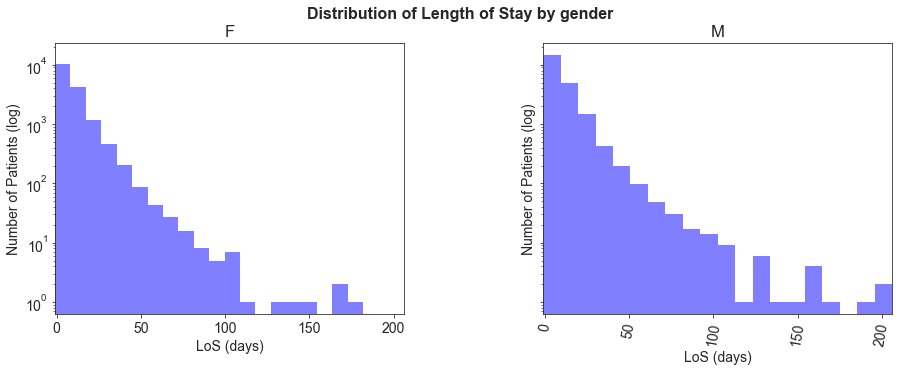

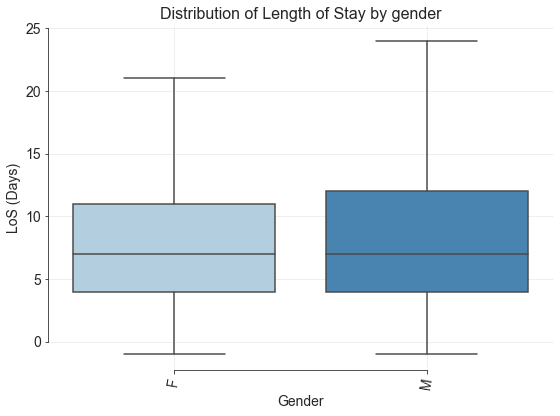

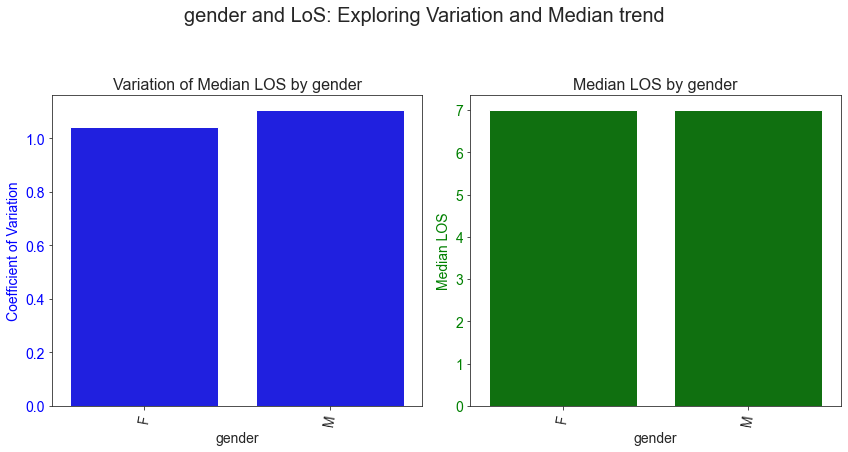

<Figure size 576x432 with 0 Axes>

In [65]:
plot_stats_by_column(comobiditiesdf,'gender') # exploring gender column with function

In [66]:
# Calculate coefficient of variation for los by religion group
comobiditiesdf['gender_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
gender_stats = comobiditiesdf.groupby('gender')['los'].agg(['mean', 'std', 'count'])
gender_stats['cv'] = gender_stats['std'] / gender_stats['mean']
#gender_stats

print(gender_stats)




# Group the data by discharge location and calculate the median of LOS
los_median_by_gender = comobiditiesdf.groupby('gender')['los'].median()

# Print the median of LOS for each age group
los_median_by_gender




            mean        std  count        cv
gender                                      
F       9.388763   9.791754  16766  1.042923
M       9.689315  10.717207  21871  1.106085


gender
F    7.0
M    7.0
Name: los, dtype: float64

## Marital Status and Length of Stay

In [56]:
comobiditiesdf['marital_status'].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

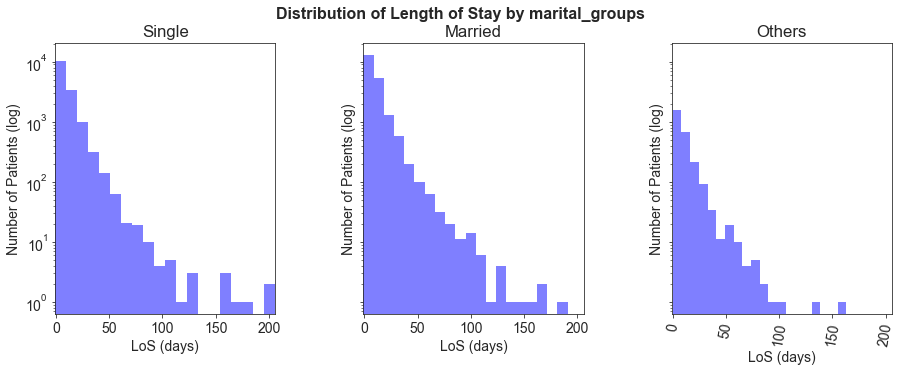

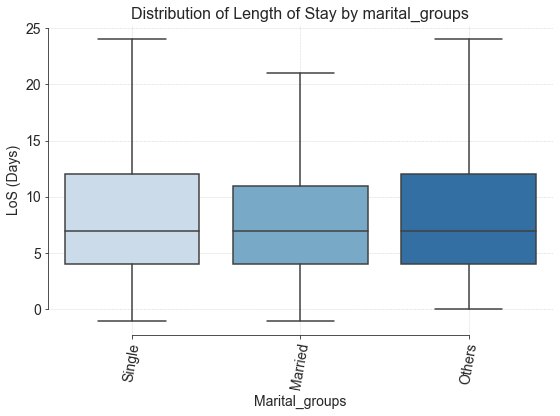

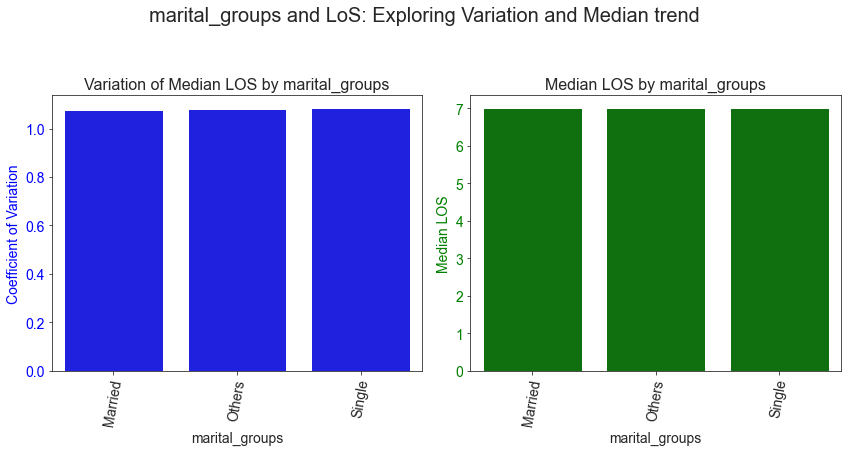

<Figure size 576x432 with 0 Axes>

In [68]:
#grouping the data into single and married
data = ['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER']

groups = {
    'Single': ['SINGLE','SEPARATED','WIDOWED'],
    'Married': ['MARRIED','LIFE PARTNER'],
}

# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['marital_status'].isin(groups['Single']),
    comobiditiesdf['marital_status'].isin(groups['Married']),
]
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['Single', 'Married']
comobiditiesdf['marital_groups'] = np.select(conditions, choices, default='Others')


#encoding marital status column
comobiditiesdf['marital_enc']= np.where(comobiditiesdf['marital_groups'] == 'Single', 1,
                                        np.where(comobiditiesdf['marital_groups']=='Married',2,3))

plot_stats_by_column(comobiditiesdf,'marital_groups')


In [69]:
# Calculate coefficient of variation for los by religion group
comobiditiesdf['marital_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
marital_stats = comobiditiesdf.groupby('marital_groups')['los'].agg(['mean', 'std', 'count'])
marital_stats['cv'] = marital_stats['std'] / marital_stats['mean']
marital_stats

print(marital_stats)

plt.show()


# Group the data by discharge location and calculate the median of LOS
los_median_by_marital_status = comobiditiesdf.groupby('marital_groups')['los'].median()

# Print the median of LOS for each age group
print(los_median_by_marital_status)



                     mean        std  count        cv
marital_groups                                       
Married          9.513414  10.249061  20724  1.077327
Others          10.065325  10.880617   2633  1.081000
Single           9.533312  10.332134  15280  1.083793
marital_groups
Married    7.0
Others     7.0
Single     7.0
Name: los, dtype: float64


## Diagnosis and Length of Stay

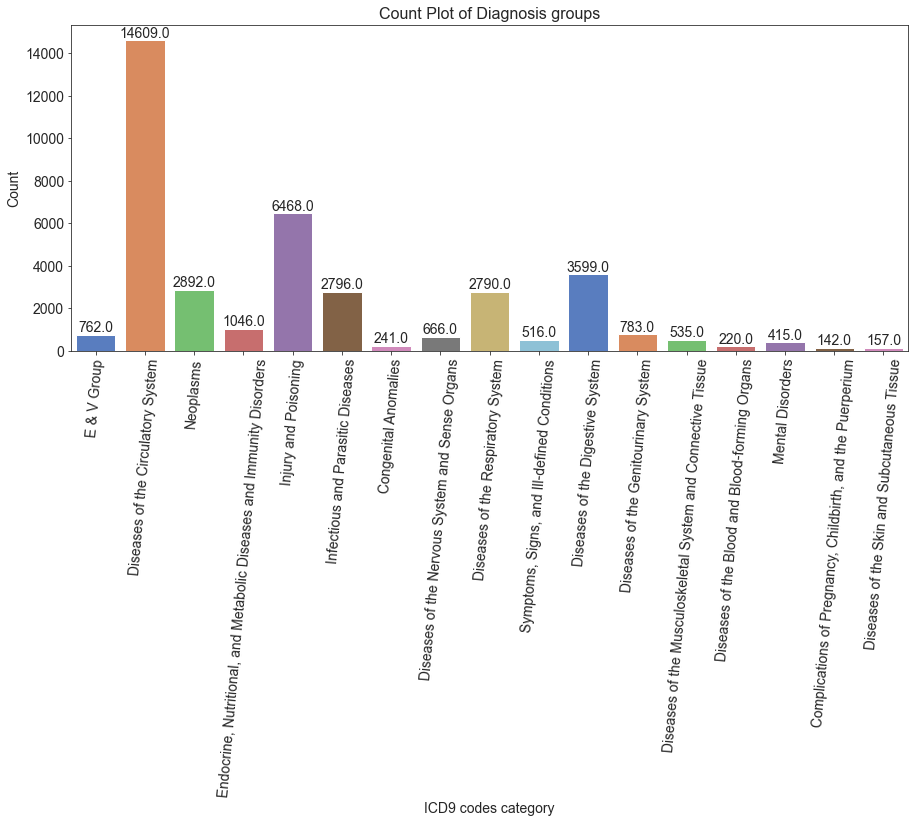

In [70]:
# Create a new figure with a width of 15 inches and a height of 6 inches.
plt.figure(figsize=(15, 6))

# Create a count plot using Seaborn library, with the 'ccs_group' column from the 'comobiditiesdf' DataFrame as the x-axis 
# and the count of each category as the y-axis. The 'muted' palette is used to color the bars.
ax = sns.countplot(x='ccs_group', data=comobiditiesdf, palette='muted')

# Add a label to the x-axis of the plot with a font size of 14.
plt.xlabel('ICD9 codes category', fontsize=14)

# Add a label to the y-axis of the plot with a font size of 14.
plt.ylabel('Count', fontsize=14)

# Rotate the x-axis labels by 85 degrees to prevent overlap.
plt.xticks(rotation = 85)

# Add a title to the plot with a font size of 16.
plt.title('Count Plot of Diagnosis groups', fontsize=16)

# Add the count of each category on top of its respective bar in the plot. The text is centered on top of the bar and aligned to the bottom.
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), p.get_height(), ha='center', va='bottom')



In [71]:
# Calculate coefficient of variation for los by religion group
comobiditiesdf['icd_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
icd9_stats = comobiditiesdf.groupby('ccs_group')['los'].agg(['mean', 'std', 'count'])
icd9_stats['cv'] = icd9_stats['std'] / icd9_stats['mean']
icd9_stats


,mean,std,count,cv
ccs_group,,,,
"Complications of Pregnancy, Childbirth, and the Puerperium",9.464789,10.744395,142,1.135196
Congenital Anomalies,7.049793,5.534514,241,0.785061
Diseases of the Blood and Blood-forming Organs,11.636364,13.077030,220,1.123807
Diseases of the Circulatory System,8.572250,8.015371,14609,0.935037
Diseases of the Digestive System,10.532648,11.370044,3599,1.079505
Diseases of the Genitourinary System,9.371648,9.941314,783,1.060786
Diseases of the Musculoskeletal System and Connective Tissue,12.000000,12.578741,535,1.048228
Diseases of the Nervous System and Sense Organs,11.139640,14.609401,666,1.311479
Diseases of the Respiratory System,10.111111,10.140101,2790,1.002867


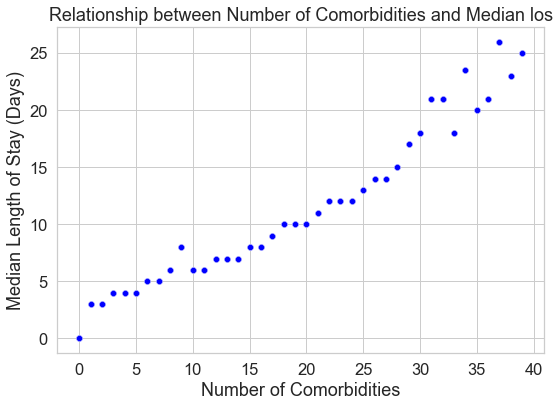

In [73]:


import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size and style for the plot
sns.set(font_scale=1.5, style="ticks")
# Set the font size and style for the plot
sns.set(font_scale=1.5, style="ticks")

# Set the style to include a grid
sns.set_style("whitegrid")

# Create the scatter plot
sns.scatterplot(
    x="num_comorbidities",
    y="median_los_comorbidities",
    data=comobiditiesdf,
    color="blue", # Set the color of the points
    alpha=0.5, # Set the transparency of the points
)

# Add labels and a title to the plot
plt.title("Relationship between Number of Comorbidities and Median los")
plt.xlabel("Number of Comorbidities")
plt.ylabel("Median Length of Stay (Days)")

# Add a caption for the figure
#plt.figtext(0.5, -0.1, "Figure 1: Scatter plot showing the relationship between the number of comorbidities and the median length of stay for patients.", ha="center", fontsize=14)

# Adjust the plot's layout to fit the labels
plt.tight_layout()

# Save the plot as a PDF for use in the paper
plt.savefig("comorbidities_scatterplot.pdf")

# Show the plot (optional)
plt.show()


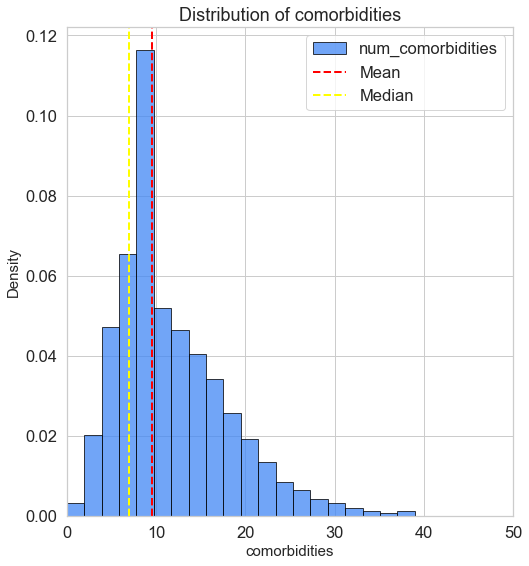

count    38637.000000
mean        11.622849
std          6.408757
min          0.000000
25%          7.000000
50%         10.000000
75%         15.000000
max         39.000000
Name: num_comorbidities, dtype: float64

In [74]:
# Create a histogram of the los column
comobiditiesdf.num_comorbidities.plot.hist(bins=20, figsize=(8,9), color='#4287f5', alpha=0.75, edgecolor='black',density=True)
plt.xlim(0,50)
plt.title('Distribution of comorbidities',fontsize =18)
plt.xlabel('comorbidities',fontsize = 15)
plt.ylabel('Density',fontsize = 15)

# Calculate the mean and median values of the los column
mean_como = comobiditiesdf.los.mean()
median_como = comobiditiesdf.los.median()

# Add vertical dashed lines for the mean and median values
plt.axvline(mean_los, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_los, color='yellow', linestyle='--', linewidth=2, label='Median')

# Add a legend to the plot
plt.legend()

# Display the figure
plt.show()
comobiditiesdf['num_comorbidities'].describe()

## Kruskal - Walli's Test

In [75]:

import scipy.stats as stats
import pandas as pd

# Define a function for the Kruskal-Wallis test
def kruskal_wallis(df, columns, group_var):
    
    # Create an empty list to store the results
    results = []
    
    # Loop through the list of columns to perform the test on
    for col in columns:
        
        # Group the dataframe by the group variable and the current column
        groups = df.groupby(group_var)[col]
        
        # Create a list of arrays, where each array contains the values of the current column for each group
        group_arrays = [group[1].values for group in groups]
        
        # Perform the Kruskal-Wallis test on the list of arrays
        kw_stat, p_value = stats.kruskal(*group_arrays)
        
        # Append the results of the Kruskal-Wallis test to the list of results
        results.append((col, kw_stat, p_value))
    
    # Convert the list of results into a dataframe
    results_df = pd.DataFrame(results, columns=['Features', 'Kruskal-Wallis test statistic', 'p-value'])
    
    # Return the dataframe
    return results_df


result_df = kruskal_wallis(comobiditiesdf, ['discharge_group', 'admission_type', 'insurance','admission_location','marital_status',
                                           'gender','age_group','religion_groups','num_comorbidities','ethnic_groups'], 'los')
print(result_df)


# set the p-value threshold for selecting predictors
p_value_threshold = 0.05

# filter the result dataframe based on the p-value threshold
strong_predictors = result_df[result_df['p-value'] < p_value_threshold]

# print the selected predictors
print("The strongest predictors are:")
print(strong_predictors['Features'].tolist())

             Features  Kruskal-Wallis test statistic        p-value
0     discharge_group                    5640.992869   0.000000e+00
1      admission_type                    1051.978734  1.307316e-143
2           insurance                     260.704730   1.245369e-10
3  admission_location                     535.959736   2.189206e-50
4      marital_status                     123.977898   6.555844e-01
5              gender                     104.579074   9.568401e-01
6           age_group                     176.293125   5.107258e-03
7     religion_groups                     375.834823   1.702701e-25
8   num_comorbidities                    5903.206392   0.000000e+00
9       ethnic_groups                     172.814584   8.408749e-03
The strongest predictors are:
['discharge_group', 'admission_type', 'insurance', 'admission_location', 'age_group', 'religion_groups', 'num_comorbidities', 'ethnic_groups']


In [76]:
#selects strongest predictors and saving in a pandas dataframe
best_pred_corrdf = comobiditiesdf[['los','age','admission_type','admission_location','discharge_location',
                                   'religion','num_comorbidities','insurance','ethnicity','diagnosis']]
best_pred_corrdf.head()

,los,age,admission_type,admission_location,discharge_location,religion,num_comorbidities,insurance,ethnicity,diagnosis
0,8.0,48.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,PROTESTANT QUAKER,9,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE"
9,16.0,66.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NOT SPECIFIED,8,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA
17,5.0,42.0,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,UNOBTAINABLE,6,Medicaid,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA
23,26.0,50.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,OTHER,1,Private,WHITE,BRAIN MASS
24,13.0,72.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,JEWISH,9,Medicare,WHITE,PANCREATIC CANCER/SDA


In [77]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# load the data into a pandas dataframe
#data = pd.read_csv('data.csv')

# extract the features and target variable
X = best_pred_corrdf.drop(['los'],axis=1)

y = best_pred_corrdf['los']# first column

# calculate the Spearman's rank correlation coefficient between each feature and the target variable
correlations = {}
for feature in X.columns:
    correlation, p_value = spearmanr(X[feature], y)
    correlations[feature] = correlation

# print the correlation coefficients for each feature
for feature, correlation in correlations.items():
    print('Correlation coefficient for', feature, ':', correlation)


Correlation coefficient for age : 0.056534260503568884
Correlation coefficient for admission_type : 0.04230146784668081
Correlation coefficient for admission_location : 0.08297402981428124
Correlation coefficient for discharge_location : 0.31530199368463796
Correlation coefficient for religion : -0.057204942869294166
Correlation coefficient for num_comorbidities : 0.3840323114084005
Correlation coefficient for insurance : -0.05266681886768535
Correlation coefficient for ethnicity : 0.005233604103680541
Correlation coefficient for diagnosis : -0.0049426775018326825


In [81]:
# select only the columns corresponding to the best predictors
best_predictorsdf = comobiditiesdf[['los','age','admission_type','admission_location','discharge_location',
                                    'num_comorbidities','insurance','religion','diagnosis']]

# print the new dataframe
best_predictorsdf


,los,age,admission_type,admission_location,discharge_location,num_comorbidities,insurance,religion,diagnosis
0,8.0,48.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,9,Private,PROTESTANT QUAKER,"FEVER,DEHYDRATION,FAILURE TO THRIVE"
9,16.0,66.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,8,Medicare,NOT SPECIFIED,CHRONIC RENAL FAILURE/SDA
17,5.0,42.0,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,6,Medicaid,UNOBTAINABLE,HEMORRHAGIC CVA
23,26.0,50.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,1,Private,OTHER,BRAIN MASS
24,13.0,72.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,9,Medicare,JEWISH,PANCREATIC CANCER/SDA
...,...,...,...,...,...,...,...,...,...
1325672,8.0,58.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,9,Private,NOT SPECIFIED,ABDOMINAL PAIN
1325681,3.0,54.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,12,Private,PROTESTANT QUAKER,SUBARACHNOID HEMORRHAGE
1325693,2.0,38.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,6,Private,NOT SPECIFIED,SICKLE CELL CRISIS
1325699,18.0,68.0,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,14,Medicare,PROTESTANT QUAKER,UPPER GI BLEED


## Data Preprocessing

In [82]:
model_data = best_predictorsdf.copy(); # copy data to new varible 

In [83]:
# Import the LabelEncoder class from the scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
le = LabelEncoder()

# Loop through each column in the 'model_data' DataFrame
for i in model_data.columns:
    
    # Check if the column datatype is 'object'
    if model_data[i].dtypes == 'object':
        
        # Use the LabelEncoder instance to transform the values in the current column to numerical values
        # The 'reshape' method is used to ensure that the input to the 'fit_transform' method is a 2D array
        model_data[i]=le.fit_transform(model_data[i].values.reshape(-1,1))


In [84]:
model_data.head()

,los,age,admission_type,admission_location,discharge_location,num_comorbidities,insurance,religion,diagnosis
0,8.0,48.0,1,2,6,9,3,16,4815
9,16.0,66.0,0,4,5,8,2,14,3017
17,5.0,42.0,1,2,0,6,1,19,5400
23,26.0,50.0,1,2,5,1,3,15,2048
24,13.0,72.0,0,4,0,9,2,10,8311


In [86]:
expired = model_data.loc[model_data['los'] == -1]
model_data = model_data.drop(expired.index)

In [87]:
# setting an abitrary cuttoff for dependent variable,(wine quality) 7 or higher are set to 1(good) otherwise 0(not good)
los_category = []
for row in model_data['los']:
    if  0<= row <= 20:
        los_category.append(1) #short
    elif 20 < row <= 60:
        los_category.append(2) #medium
    else:
        los_category.append(3) #long
model_data['los_category'] = los_category # adding a new column to the dataset this will be my target variable
model_data



,los,age,admission_type,admission_location,discharge_location,num_comorbidities,insurance,religion,diagnosis,los_category
0,8.0,48.0,1,2,6,9,3,16,4815,1
9,16.0,66.0,0,4,5,8,2,14,3017,1
17,5.0,42.0,1,2,0,6,1,19,5400,1
23,26.0,50.0,1,2,5,1,3,15,2048,2
24,13.0,72.0,0,4,0,9,2,10,8311,1
...,...,...,...,...,...,...,...,...,...,...
1325672,8.0,58.0,1,1,4,9,3,14,222,1
1325681,3.0,54.0,1,2,5,12,3,16,11261,1
1325693,2.0,38.0,1,1,4,6,3,14,10819,1
1325699,18.0,68.0,1,2,11,14,2,16,12043,1


In [89]:
#selecting independent a dependent variable
y_b = model_data['los_category']#dependent variables
X = model_data.drop(['los_category','los'], axis =1) #independent variables

In [90]:
y = y_b.copy() # making a copy of dependend variable

In [91]:
# normalising the independent variable using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-0.91074687,  0.31977854, -0.49585004, ...,  1.05927672,
         0.93214075, -0.36751012],
       [ 0.11698317, -2.13327538,  0.86083979, ..., -0.3057808 ,
         0.6088771 , -0.85623023],
       [-1.25332355,  0.31977854, -0.49585004, ..., -1.67083832,
         1.41703624, -0.20849941],
       ...,
       [-1.481708  ,  0.31977854, -1.17419496, ...,  1.05927672,
         0.6088771 ,  1.26445623],
       [ 0.2311754 ,  0.31977854, -0.49585004, ..., -0.3057808 ,
         0.93214075,  1.59715557],
       [-0.73945853,  0.31977854, -1.17419496, ..., -0.3057808 ,
         0.77050893,  0.68821228]])

In [92]:
#oversampling the data using smote technique
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X,y = sm.fit_resample(X,y)

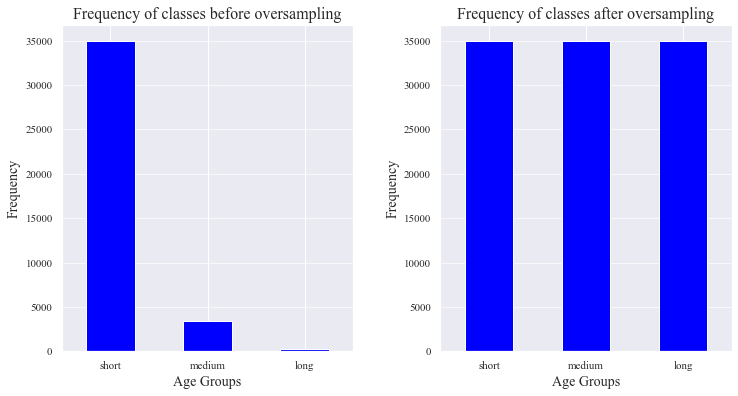

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font to a consistent font with the paper
sns.set(font='Times New Roman')

# Create the subplots with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Modify x-tick labels to "young", "mid-age", and "old"
xtick_labels = ['short', 'medium', 'long']

# Plot the first bar chart
y_b.value_counts().plot(kind='bar', color='blue', ax=axs[0])

# Add the grid and labels
axs[0].grid(axis='y', alpha=0.7)
axs[0].set_xlabel('Age Groups', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Frequency of classes before oversampling', fontsize=16)
axs[0].set_xticklabels(xtick_labels, rotation=0)

# Plot the second bar chart
y.value_counts().plot(kind='bar', color='blue', ax=axs[1])

# Add the grid and labels
axs[1].grid(axis='y', alpha=0.7)
axs[1].set_xlabel('Age Groups', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Frequency of classes after oversampling', fontsize=16)
axs[1].set_xticklabels(xtick_labels, rotation=0)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Show the chart
plt.show()


In [85]:
len(y)

104991

## Logistics Regression

In [94]:

# Import the necessary libraries for the code
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score

# Create an instance of the OneVsRestClassifier class with LogisticRegression as the estimator
lr = OneVsRestClassifier(LogisticRegression())

# Loop through 100 random states
for i in range(0,100):
    
    # Split the data into training and testing sets with a test size of 20% and the current random state
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =i, test_size = 0.20)
    
    # Fit the OneVsRestClassifier model on the training data
    lr.fit(X_train,y_train)
    
    # Predict the classes for the training and testing data
    pred_train= lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    # Check if the training and testing accuracies are equal up to 1 decimal place
    if round(accuracy_score(y_train,pred_train)*100,1)== round(accuracy_score(y_test,pred_test)*100,1):
        
        # Print the model performance metrics for the current random state
        print('At random state',i, 'the model reports:')
        print('At random state:-', i)
        print('Training accuracy is:', accuracy_score(y_train,pred_train)*100)
        print('Testing accuracy is:', accuracy_score(y_test,pred_test)*100)
        print('\n')


At random state 20 the model reports:
At random state:- 20
Training accuracy is: 51.12034479474236
Testing accuracy is: 51.08338492309158


At random state 32 the model reports:
At random state:- 32
Training accuracy is: 51.11201066768264
Testing accuracy is: 51.064336396971285


At random state 45 the model reports:
At random state:- 45
Training accuracy is: 51.14772835508143
Testing accuracy is: 51.12148197533216


At random state 66 the model reports:
At random state:- 66
Training accuracy is: 51.18939899038004
Testing accuracy is: 51.221486737463685


At random state 67 the model reports:
At random state:- 67
Training accuracy is: 51.0774835698638
Testing accuracy is: 51.08814705462164


At random state 88 the model reports:
At random state:- 88
Training accuracy is: 51.1251071530622
Testing accuracy is: 51.11671984380208




In [95]:
# calculating classification metric report for each class
class_names = ['short', 'medium', 'long']
print(classification_report(y_test,pred_test,target_names=class_names))

              precision    recall  f1-score   support

       short       0.54      0.72      0.62      7015
      medium       0.44      0.27      0.33      7040
        long       0.51      0.54      0.53      6944

    accuracy                           0.51     20999
   macro avg       0.50      0.51      0.49     20999
weighted avg       0.50      0.51      0.49     20999



In [96]:

# Predict the classes for the testing data using the trained model
pred_lr = lr.predict(X_test)

# Import the necessary libraries for cross-validation
from sklearn.model_selection import cross_val_score

# Compute the accuracy score for the predicted labels and the actual labels
lss = accuracy_score(y_test,pred_lr)

# Loop through cross-validation folds from 2 to 9
for i in range(2,10):
    
    # Compute the cross-validation score for the current number of folds
    lsscore = cross_val_score(lr,X,y, cv =i)
    
    # Compute the mean cross-validation score across all folds
    lsc = lsscore.mean()
    
    # Print the cross-validation and accuracy scores for the current number of folds
    print('At cv:',i)
    print('cross validation score is:-', lsc*100)
    print('accuracy_score is:-',lss*100)
    print('\n')


At cv: 2
cross validation score is:- 49.34039154583132
accuracy_score is:- 50.969093766369824


At cv: 3
cross validation score is:- 50.52433065691345
accuracy_score is:- 50.969093766369824


At cv: 4
cross validation score is:- 50.65764054258557
accuracy_score is:- 50.969093766369824


At cv: 5
cross validation score is:- 50.79480401601678
accuracy_score is:- 50.969093766369824


At cv: 6
cross validation score is:- 50.86523136734582
accuracy_score is:- 50.969093766369824


At cv: 7
cross validation score is:- 50.893821867539536
accuracy_score is:- 50.969093766369824


At cv: 8
cross validation score is:- 50.95004680238876
accuracy_score is:- 50.969093766369824


At cv: 9
cross validation score is:- 50.97189167652394
accuracy_score is:- 50.969093766369824




In [98]:
#printing the predicted probabilities and checking the shape
pred_prob = lr.predict_proba(X_test)
pred_prob.shape

(20999, 3)

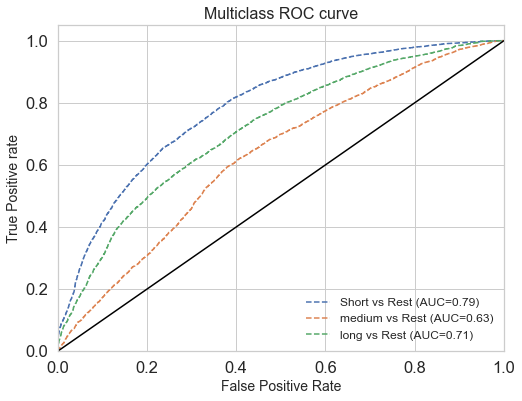

In [99]:
# Plottin ROC AUC curves 

import numpy as np                   # import numpy library for numerical operations
import matplotlib.pyplot as plt      # import pyplot module from matplotlib for plotting
from sklearn.metrics import roc_curve, auc   # import required metrics for computing ROC curve

classes = np.unique(y_test)          # get unique classes in y_test variable
class_names = ['Short','medium','long'] # create list of class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))   # binarize y_test variable

# roc curves for each class
fpr = {}     # dictionary to store false positive rate for each class
tpr = {}     # dictionary to store true positive rate for each class
threshold = {}  # dictionary to store threshold values for each class
roc_auc = {}    # dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]     # get number of classes

# calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)' % (class_names[i], roc_auc[i]))

# plot diagonal line representing no skill
plt.plot([0, 1], [0, 1], 'black')

# set plot limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC curve',fontsize=16)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive rate',fontsize=14)

# add legend to the plot
plt.legend(loc='lower right',frameon=False,fontsize=12)

# show the plot
plt.show()



## Support Vector Machine

In [92]:
#developing a support vector model and checking the accuracy

from sklearn.svm import SVC  # import the support vector machine classifier

svc = OneVsRestClassifier(SVC())  # create an instance of the one-vs-rest classifier with the support vector machine as the base estimator

svc.fit(X_train, y_train)  # fit the one-vs-rest classifier to the training data

predsvc = svc.predict(X_test)  # make predictions on the test data using the fitted classifier

print(accuracy_score(y_test, predsvc))  # print the accuracy score of the predictions

print(confusion_matrix(y_test,predsvc))  # print the confusion matrix of the predictions

print(classification_report(y_test,predsvc))  # print the classification report of the predictions


0.7486070765274537
[[5201 1212  587]
 [1616 4147 1286]
 [ 201  377 6372]]
              precision    recall  f1-score   support

           1       0.74      0.74      0.74      7000
           2       0.72      0.59      0.65      7049
           3       0.77      0.92      0.84      6950

    accuracy                           0.75     20999
   macro avg       0.75      0.75      0.74     20999
weighted avg       0.75      0.75      0.74     20999



In [93]:
y_score = svc.decision_function(X_test) ##calculating  predicted probabilities
y_score
y_prob = np.exp(y_score) / np.sum(np.exp(y_score), axis=1, keepdims=True)


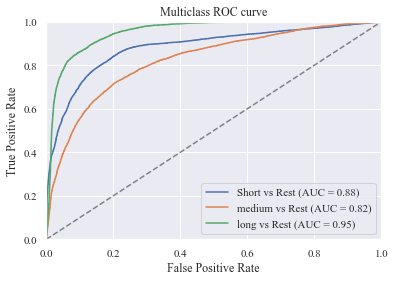

In [94]:

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

classes = np.unique(y_test)
class_names = ['Short','medium','long'] # list of original class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {}# dictionary to store false positive rate for each class
tpr = {}# dictionary to store true positive rate for each class
threshold = {}# dictionary to store threshold values for each class
roc_auc = {}# dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]  # get number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
   # Plot ROC curves
fig, ax = plt.subplots()
for i in range(n_classes):
    roc_display = plot_roc_curve(svc.estimators_[i], X_test, y_test_binarize[:, i], 
                                 name=f'{class_names[i]} vs Rest', ax=ax)
    # plot diagonal line representing no skill
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [140]:
# checking cv score for support vector machine classifier
score = cross_val_score(svc,X,y)  # calculate the cross validation scores for the SVC model
print(score)  # print the array of cross validation scores
print(score.mean())  # print the mean of the cross validation scores
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predsvc)-score.mean())  # print the difference between accuracy score and mean of cross validation score

[0.68832369 0.69814716 0.702913   0.70134228 0.69978601]
0.6981024279365357
Difference between accuracy and cross validation score is 0.01361278871473115


## Random Forest

In [95]:
#developing Random forest model

# Define an instance of OneVsRestClassifier that uses a RandomForestClassifier as the base estimator
RFC = OneVsRestClassifier(RandomForestClassifier())

# Train the classifier using the training data X_train and y_train
RFC.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predRFC = RFC.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test,predRFC))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predRFC))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predRFC))


0.9590456688413734
[[6507  455   38]
 [ 303 6708   38]
 [  19    7 6924]]
              precision    recall  f1-score   support

           1       0.95      0.93      0.94      7000
           2       0.94      0.95      0.94      7049
           3       0.99      1.00      0.99      6950

    accuracy                           0.96     20999
   macro avg       0.96      0.96      0.96     20999
weighted avg       0.96      0.96      0.96     20999



In [96]:
pred_p = RFC.predict_proba(X_test) #calculating the predicted probabilities 
pred_p.shape
pred_p

array([[0.03846154, 0.03846154, 0.92307692],
       [0.98039216, 0.01960784, 0.        ],
       [0.08490566, 0.91509434, 0.        ],
       ...,
       [0.        , 0.03030303, 0.96969697],
       [0.01941748, 0.02912621, 0.95145631],
       [0.48623853, 0.51376147, 0.        ]])

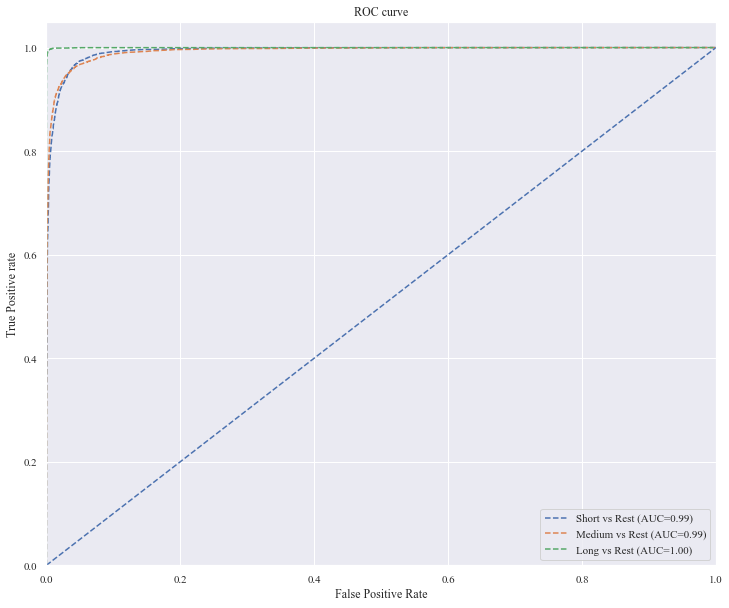

In [97]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, label_binarize

#classes = np.unique(y_test)
class_names = ['Short','Medium','Long']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {}# dictionary to store false positive rate for each class
tpr = {}# dictionary to store true positive rate for each class
threshold = {}# dictionary to store threshold values for each class
roc_auc = {}# dictionary to store ROC AUC value for each class

n_classes = classes.shape[0] #get the number of classes

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_p[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))
    
#ploting the diagonal line
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [261]:
score = cross_val_score(RFC,X,y)
print(score)
print(score.mean())
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predRFC)-score.mean())

[0.91454701 0.96770506 0.9680846  0.96460725 0.96379746]
0.9557482755959412
Difference between accuracy and cross validation score is 0.004335557880290053


## Gradient Booster

In [98]:
#checking accuracy for Gradient boosting classifier
# Define an instance of OneVsRestClassifier that uses a GradientBoostingClassifier as the base estimator
GB = OneVsRestClassifier(GradientBoostingClassifier())

# Train the classifier using the training data X_train and y_train
GB.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predGB = GB.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test, predGB))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predGB))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predGB))


0.7877994190199533
[[5865  858  277]
 [ 835 4955 1259]
 [  51 1176 5723]]
              precision    recall  f1-score   support

           1       0.87      0.84      0.85      7000
           2       0.71      0.70      0.71      7049
           3       0.79      0.82      0.81      6950

    accuracy                           0.79     20999
   macro avg       0.79      0.79      0.79     20999
weighted avg       0.79      0.79      0.79     20999



In [331]:
# Use cross-validation to calculate the score of the classifier on the entire dataset
score = cross_val_score(GB,X,y)

# Print the individual scores for each fold of cross-validation
print(score)

# Print the mean score across all folds of cross-validation
print(score.mean())

# Calculate and print the difference between the accuracy of the classifier's predictions on the test data and the mean score of the cross-validation
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predGB)-score.mean())


[0.74340288 0.78917786 0.78835802 0.78240366 0.77849759]
0.7763680028510708
Difference between accuracy and cross validation score is 0.0004253666830817959


<Figure size 576x432 with 0 Axes>

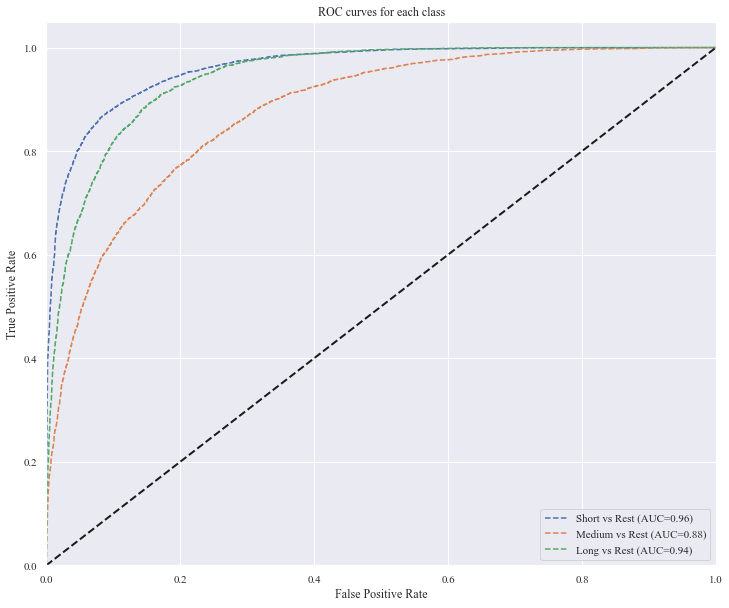

In [99]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Medium','Long']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))


#plt.plot(fpr[i], tpr[i], linestyle='--', 
            #label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each class')
plt.legend(loc="lower right")
plt.show()


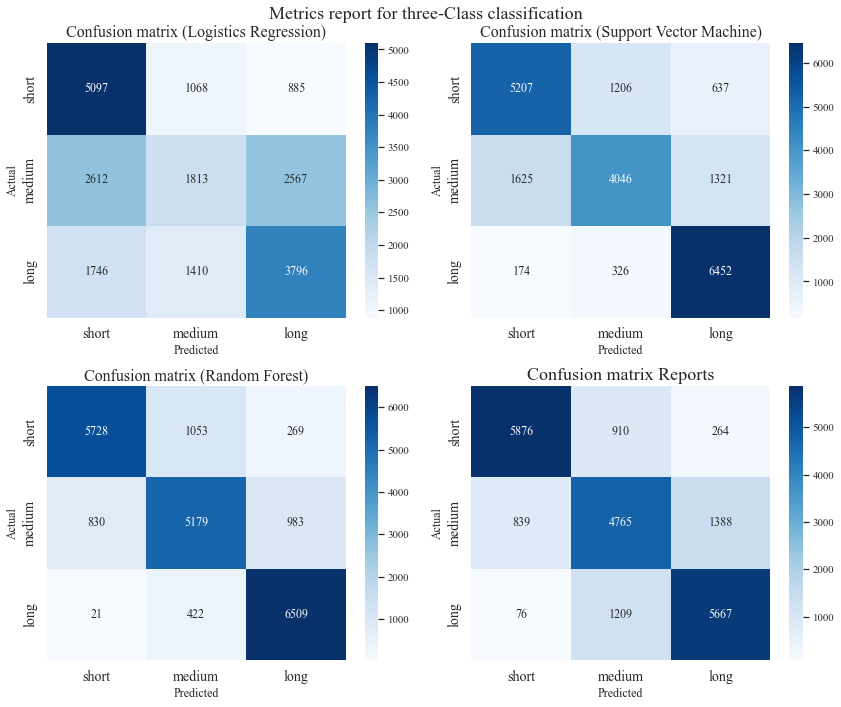

In [318]:
# Create a 2x2 grid of subplots with a specified figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Create a list of model names and their corresponding predicted values
model_names = ['Logistics Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Booster']

# Loop through each model name and its corresponding predicted values
for i, (model_name, y_pred) in enumerate(zip(model_names, [pred_test, predsvc, predRFC, predGB])):
    # Calculate the row and column index of the current subplot
    row = i // 2
    col = i % 2
    
    # Select the current subplot using its row and column index
    ax = axes[row][col]
    
    # Calculate the confusion matrix for the current model's predictions on the test data
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap of the confusion matrix with annotations, a blue color map, and labeled tick marks
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax, 
                xticklabels=['short', 'medium','long'], 
                yticklabels=['short', 'medium','long'])
    
    # Set the x-axis and y-axis labels and title for the current subplot
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Confusion matrix ({model_name})', fontsize=16)
    
    # Set the font size of the tick labels for the current subplot
    ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust the layout of the subplots to fit the title and suptitle
plt.tight_layout()
plt.title('Confusion matrix Reports', fontsize=18)
plt.suptitle('Metrics report for three-Class classification', fontsize=18)
plt.subplots_adjust(top=0.93)

# Display the plot
plt.show()



### Hyperparameter Tunning

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Create Random Forest Classifier object
RFC = RandomForestClassifier()

# Create GridSearchCV object
grid_rfc = GridSearchCV(estimator=RFC,
                        param_grid=param_grid,
                        cv=5, # 5-fold cross validation
                        n_jobs=-1, # use all available processors
                        scoring='accuracy')

# Fit GridSearchCV object to data
grid_rfc.fit(X, y)

# Print best hyperparameters and corresponding score
print('Best hyperparameters:', grid_rfc.best_params_)
print('Best score:', grid_rfc.best_score_)


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8119174289664173


In [109]:
#training a model using the best parameters after hyperparameter tunning
RFC = OneVsRestClassifier(RandomForestClassifier(max_depth= 10, min_samples_split=2, n_estimators= 200))
RFC.fit(X_train,y_train)
predRFC = RFC.predict(X_test)
print(accuracy_score(y_test,predRFC))
print(confusion_matrix(y_test,predRFC))
print(classification_report(y_test,predRFC))

0.8337063669698557
[[5684 1050  266]
 [ 797 5301  951]
 [  37  391 6522]]
              precision    recall  f1-score   support

           1       0.87      0.81      0.84      7000
           2       0.79      0.75      0.77      7049
           3       0.84      0.94      0.89      6950

    accuracy                           0.83     20999
   macro avg       0.83      0.83      0.83     20999
weighted avg       0.83      0.83      0.83     20999



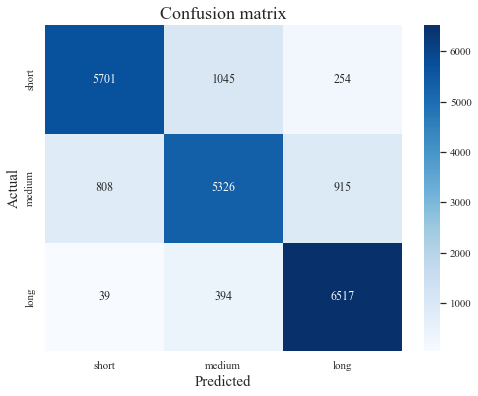

In [103]:
# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, predRFC)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
                    xticklabels=['short', 'medium','long'], yticklabels=['short', 'medium','long'])
plt.xlabel('Predicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.title('Confusion matrix',fontsize=18)
plt.show()

In [104]:
pred_p = RFC.predict_proba(X_test) #calculating the predicted probablities and checking the shape
pred_p.shape
pred_p

array([[0.1401328 , 0.18559294, 0.67427426],
       [0.87561367, 0.07268433, 0.051702  ],
       [0.28268831, 0.64067532, 0.07663637],
       ...,
       [0.22885578, 0.25114362, 0.5200006 ],
       [0.16926492, 0.36366082, 0.46707426],
       [0.19393937, 0.47940855, 0.32665208]])

<Figure size 576x432 with 0 Axes>

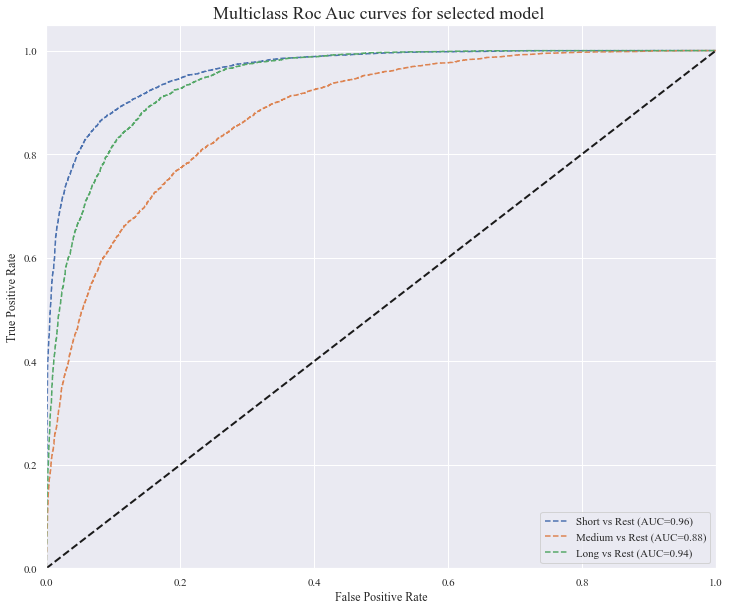

In [105]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Medium','Long']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green', 'orange', 'purple'] # Define colors for the curves

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))


#plt.plot(fpr[i], tpr[i], linestyle='--', 
            #label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Roc Auc curves for selected model ',fontsize=18)
plt.legend(loc="lower right")
plt.show()
